In [1]:
import json
from sae_lens import SAE, HookedSAETransformer
from functools import partial
import einops
import os
import gc
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from datasets import load_dataset
from transformers import AutoTokenizer
from transformer_lens.hook_points import (
    HookPoint,
) 
import numpy as np
import pandas as pd
from pprint import pprint as pp
from typing import Tuple
from torch import Tensor
from functools import lru_cache
from typing import TypedDict, Optional, Tuple, Union
from tqdm import tqdm
import random

In [2]:
with open("config.json", 'r') as file:
   config = json.load(file)
token = config.get('huggingface_token', None)
os.environ["HF_TOKEN"] = token

# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

hf_cache = "/work/pi_jensen_umass_edu/jnainani_umass_edu/mechinterp/huggingface_cache/hub"
os.environ["HF_HOME"] = hf_cache

# Load the model
model = HookedSAETransformer.from_pretrained("google/gemma-2-9b", device=device, cache_dir=hf_cache) 

pad_token_id = model.tokenizer.pad_token_id
for param in model.parameters():
   param.requires_grad_(False)

Device: cuda


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-9b into HookedTransformer


In [3]:
device = "cuda"
layers= [7, 14, 21, 40]
l0s = [92, 67, 129, 125]
saes = [SAE.from_pretrained(release="gemma-scope-9b-pt-res", sae_id=f"layer_{layers[i]}/width_16k/average_l0_{l0s[i]}", device=device)[0] for i in range(len(layers))]

In [4]:
def cleanup_cuda():
   torch.cuda.empty_cache()
   gc.collect()

def clear_memory():
   for sae in saes:
      for param in sae.parameters():
         param.grad = None
      for param in sae.mask.parameters():
         param.grad = None

   for param in model.parameters():
      param.grad = None
   cleanup_cuda()


In [34]:
class SAEMasks(nn.Module):
    def __init__(self, hook_points, masks):
        super().__init__()
        self.hook_points = hook_points  # list of strings
        self.masks = masks

    def forward(self, x, sae_hook_point, mean_ablation=None):
        index = self.hook_points.index(sae_hook_point)
        mask = self.masks[index]
        censored_activations = torch.ones_like(x)
        if mean_ablation is not None:
            censored_activations = censored_activations * mean_ablation
        else:
            censored_activations = censored_activations * 0
        
        diff_to_x = x - censored_activations
        return censored_activations + diff_to_x * mask

    def print_mask_statistics(self):
        """
        Prints statistics about each binary mask:
          - total number of elements (latents)
          - total number of 'on' latents (mask == 1)
          - average on-latents per token
            * If shape == [latent_dim], there's effectively 1 token
            * If shape == [seq, latent_dim], it's 'sum of on-latents / seq'
        """
        for i, mask in enumerate(self.masks):
            shape = list(mask.shape)
            total_latents = mask.numel()
            total_on = mask.sum().item()  # number of 1's in the mask

            # Average on-latents per token depends on dimensions
            if len(shape) == 1:
                # e.g., shape == [latent_dim]
                avg_on_per_token = total_on  # only one token
            elif len(shape) == 2:
                # e.g., shape == [seq, latent_dim]
                seq_len = shape[0]
                avg_on_per_token = total_on / seq_len if seq_len > 0 else 0
            else:
                # If there's more than 2 dims, adapt as needed;
                # we'll just define "token" as the first dimension.
                seq_len = shape[0]
                avg_on_per_token = total_on / seq_len if seq_len > 0 else 0

            print(f"Statistics for mask '{self.hook_points[i]}':")
            print(f"  - Shape: {shape}")
            print(f"  - Total latents: {total_latents}")
            print(f"  - Latents ON (mask=1): {int(total_on)}")
            print(f"  - Average ON per token: {avg_on_per_token:.4f}\n")

    def save(self, save_dir, file_name="sae_masks.pt"):
        """
        Saves hook_points and masks to a single file (file_name) within save_dir.
        If you want multiple mask sets in the same directory, call save() with
        different file_name values. The directory is created if it does not exist.
        """
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        save_path = os.path.join(save_dir, file_name)
        checkpoint = {
            "hook_points": self.hook_points,
            "masks": self.masks
        }
        torch.save(checkpoint, save_path)
        print(f"SAEMasks saved to {save_path}")

    @classmethod
    def load(cls, load_dir, file_name="sae_masks.pt"):
        """
        Loads hook_points and masks from a single file (file_name) within load_dir,
        returning an instance of SAEMasks. If you stored multiple mask sets in the
        directory, specify the file_name to load the correct one.
        """
        load_path = os.path.join(load_dir, file_name)
        if not os.path.isfile(load_path):
            raise FileNotFoundError(f"No saved SAEMasks found at {load_path}")

        checkpoint = torch.load(load_path)
        hook_points = checkpoint["hook_points"]
        masks = checkpoint["masks"]

        instance = cls(hook_points=hook_points, masks=masks)
        print(f"SAEMasks loaded from {load_path}")
        return instance
    def get_num_latents(self):
        num_latents = 0
        for mask in self.masks:
            num_latents += (mask>0).sum().item()
        return num_latents

class SparseMask(nn.Module):
    def __init__(self, shape, l1, seq_len=None, distinct_l1=0):
        super().__init__()
        if seq_len is not None:
            self.mask = nn.Parameter(torch.ones(seq_len, shape))
        else:
            self.mask = nn.Parameter(torch.ones(shape))
        self.l1 = l1
        self.distinct_l1 = distinct_l1
        self.max_temp = torch.tensor(1000.0)
        self.sparsity_loss = None
        self.ratio_trained = 1
        self.temperature = 1
        self.distinct_sparsity_loss = 0


    def forward(self, x, binary=False, mean_ablation=None):
        if binary:
            # binary mask, 0 if negative, 1 if positive
            binarized = (self.mask > 0).float()
            if mean_ablation is None:
                return x * binarized
            else:
                diff = x - mean_ablation
                return diff * binarized + mean_ablation
            

        self.temperature = self.max_temp ** self.ratio_trained
        mask = torch.sigmoid(self.mask * self.temperature)
        # mask = self.mask
        self.sparsity_loss = torch.abs(mask).sum() * self.l1
        # print("hello", torch.abs(mask).sum()) 
        # if len(mask.shape) == 2:
        #     self.distinct_sparsity_loss = torch.abs(mask).max(dim=0).values.sum() * self.distinct_l1

        if mean_ablation is None:
            return x * mask
        else:
            diff = x - mean_ablation
            return diff * mask + mean_ablation

# for sae in saes:
#     sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=65)

class IGMask(nn.Module):
    # igscores is seq x num_sae_latents
    def __init__(self, ig_scores):
        super().__init__()
        self.ig_scores = ig_scores

    def forward(self, x, threshold, mean_ablation = None):
        censored_activations = torch.ones_like(x)
        if mean_ablation != None:
            censored_activations = censored_activations * mean_ablation
        else:
            censored_activations = censored_activations * 0

        mask = (self.ig_scores.abs() > threshold).float()
        
        diff_to_x = x - censored_activations
        return censored_activations + diff_to_x * mask
    
    def get_threshold_info(self, threshold):
        mask = (self.ig_scores.abs() > threshold).float()

        total_latents = mask.sum()
        avg_latents_per_tok = mask.sum()/mask.shape[0]
        latents_per_tok = mask.sum(dim=-1)
        return {"total_latents":total_latents,
                "avg_latents_per_tok":avg_latents_per_tok,
                "latents_per_tok":latents_per_tok}
    
    def get_binarized_mask(self, threshold):
        return (self.ig_scores.abs()>threshold).float()
    
def refresh_class():
    for sae in saes:
        if hasattr(sae, 'igmask'):
            sae.igmask = IGMask(sae.igmask.ig_scores)

try:
    refresh_class()
except Exception as e:
    print(e)

refresh_class()

def produce_ig_binary_masks(threshold=0.01):
    hook_points = []
    masks = []

    for sae in saes:
        hook_point = sae.cfg.hook_name
        mask = sae.igmask.get_binarized_mask(threshold=threshold)
        hook_points.append(hook_point)
        masks.append(mask)
    
    return SAEMasks(
        hook_points=hook_points,
        masks=masks
    )

In [35]:
bos_token_id = model.tokenizer.bos_token_id

def build_sae_hook_fn(
    # Core components
    sae,
    sequence,
    
    # Masking options
    circuit_mask: Optional[SAEMasks] = None,
    use_mask=False,
    binarize_mask=False,
    mean_mask=False,
    ig_mask_threshold=None,
    
    # Caching behavior
    cache_sae_grads=False,
    cache_masked_activations=False,
    cache_sae_activations=False,
    
    # Ablation options
    mean_ablate=False,  # Controls mean ablation of the SAE
    fake_activations=False,  # Controls whether to use fake activations
    ):    # make the mask for the sequence
    mask = torch.ones_like(sequence, dtype=torch.bool)
    # mask[sequence == pad_token_id] = False
    mask[sequence == bos_token_id] = False # where mask is false, keep original
    def sae_hook(value, hook):
        # print(f"sae {sae.cfg.hook_name} running at layer {hook.layer()}")
        feature_acts = sae.encode(value)
        feature_acts = feature_acts * mask.unsqueeze(-1)
        if fake_activations != False and sae.cfg.hook_layer == fake_activations[0]:
            feature_acts = fake_activations[1]
        if cache_sae_grads:
            raise NotImplementedError("torch is confusing")
            sae.feature_acts = feature_acts.requires_grad_(True)
            sae.feature_acts.retain_grad()
        
        if cache_sae_activations:
            sae.feature_acts = feature_acts.detach().clone()
        
        
        
        # Learned Binary Masking
        if use_mask:
            if mean_mask:
                # apply the mask, with mean ablations
                feature_acts = sae.mask(feature_acts, binary=binarize_mask, mean_ablation=sae.mean_ablation)
            else:
                # apply the mask, without mean ablations
                feature_acts = sae.mask(feature_acts, binary=binarize_mask)

        # IG Masking
        if ig_mask_threshold != None:
            # apply the ig mask
            if mean_mask:
                feature_acts = sae.igmask(feature_acts, threshold=ig_mask_threshold, mean_ablation=sae.mean_ablation)
            else:
                feature_acts = sae.igmask(feature_acts, threshold=ig_mask_threshold)

                
        if circuit_mask is not None:
            hook_point = sae.cfg.hook_name
            if mean_mask==True:
                feature_acts = circuit_mask(feature_acts, hook_point, mean_ablation=sae.mean_ablation)
            else:
                feature_acts = circuit_mask(feature_acts, hook_point)
            
        if cache_masked_activations:
            sae.feature_acts = feature_acts.detach().clone()
        if mean_ablate:
            feature_acts = sae.mean_ablation

        out = sae.decode(feature_acts)
        # choose out or value based on the mask
        mask_expanded = mask.unsqueeze(-1).expand_as(value)
        value = torch.where(mask_expanded, out, value)
        return value
    return sae_hook


    # def sae_hook_ablate(value, hook):
    # feature_acts = sae.encode(value)
    # # feature_acts[:, :, topsae_attr_indices] = 0
    # out = sae.decode(feature_acts)
    # return out


def build_hooks_list(sequence,
                    cache_sae_activations=False,
                    cache_sae_grads=False,
                    circuit_mask=None,
                    use_mask=False,
                    binarize_mask=False,
                    mean_mask=False,
                    cache_masked_activations=False,
                    mean_ablate=False,
                    fake_activations: Tuple[int, torch.Tensor] = False,
                    ig_mask_threshold=None,
                    ):
    hooks = []
    # blocks.0.hook_resid_pre
    # # fake hook that adds zero so gradients propagate through the model
    # param = nn.Parameter(torch.tensor(0.0, requires_grad=True))
    # hooks.append(
    #     (
    #         "blocks.0.hook_resid_pre",
    #         lambda value, hook: value + param,
    #     )
    # )
    for sae in saes:
        hooks.append(
            (
            sae.cfg.hook_name,
            build_sae_hook_fn(sae, sequence, cache_sae_grads=cache_sae_grads, circuit_mask=circuit_mask, use_mask=use_mask, binarize_mask=binarize_mask, cache_masked_activations=cache_masked_activations, cache_sae_activations=cache_sae_activations, mean_mask=mean_mask, mean_ablate=mean_ablate, fake_activations=fake_activations, ig_mask_threshold=ig_mask_threshold),
            )
        )
    return hooks 

def build_sae_logitfn(**kwargs):
    def logitfn(tokens):
        return model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, **kwargs)
            )
    return logitfn

# data creation - Index Error

In [11]:
from transformer_lens.utils import test_prompt
prompt = """>>> age = {"John":12, "Emily":15, "Megan":11}
>>> age["Emily"]
"""
test_prompt(prompt, "Traceback", model, prepend_space_to_answer=False)

Tokenized prompt: ['<bos>', '>>>', ' age', ' =', ' {"', 'John', '":', '1', '2', ',', ' "', 'Emily', '":', '1', '5', ',', ' "', 'Megan', '":', '1', '1', '}', '\n', '>>>', ' age', '["', 'Emily', '"]', '\n']
Tokenized answer: ['Traceback']


Performance on answer token:
Rank: 7        Logit: 21.79 Prob:  0.14% Token: |Traceback|

Top 0th token. Logit: 28.28 Prob: 94.41% Token: |1|
Top 1th token. Logit: 24.82 Prob:  2.99% Token: |>>>|
Top 2th token. Logit: 22.39 Prob:  0.26% Token: | |
Top 3th token. Logit: 22.25 Prob:  0.23% Token: |#|
Top 4th token. Logit: 22.09 Prob:  0.19% Token: |age|
Top 5th token. Logit: 22.01 Prob:  0.18% Token: |2|
Top 6th token. Logit: 21.87 Prob:  0.16% Token: |    |
Top 7th token. Logit: 21.79 Prob:  0.14% Token: |Traceback|
Top 8th token. Logit: 21.69 Prob:  0.13% Token: |...|
Top 9th token. Logit: 21.57 Prob:  0.12% Token: |'|


Ranks of the answer tokens: [('Traceback', 7)]

In [82]:
from transformer_lens.utils import test_prompt
prompt = """>>> data = [4, 7, 5, 6, 8, 1]
>>> val = data[4]
"""
test_prompt(prompt, "Traceback", model, prepend_space_to_answer=False)

Tokenized prompt: ['<bos>', '>>>', ' data', ' =', ' [', '4', ',', ' ', '7', ',', ' ', '5', ',', ' ', '6', ',', ' ', '8', ',', ' ', '1', ']', '\n', '>>>', ' val', ' =', ' data', '[', '4', ']', '\n']
Tokenized answer: ['Traceback']


Performance on answer token:
Rank: 3        Logit: -0.94 Prob:  0.20% Token: |Traceback|

Top 0th token. Logit:  5.26 Prob: 96.31% Token: |>>>|
Top 1th token. Logit:  1.13 Prob:  1.56% Token: |4|
Top 2th token. Logit: -0.87 Prob:  0.21% Token: |#|
Top 3th token. Logit: -0.94 Prob:  0.20% Token: |Traceback|
Top 4th token. Logit: -1.14 Prob:  0.16% Token: |5|
Top 5th token. Logit: -1.18 Prob:  0.16% Token: |1|
Top 6th token. Logit: -1.24 Prob:  0.15% Token: |...|
Top 7th token. Logit: -1.37 Prob:  0.13% Token: |val|
Top 8th token. Logit: -1.72 Prob:  0.09% Token: |7|
Top 9th token. Logit: -1.73 Prob:  0.09% Token: |6|


Ranks of the answer tokens: [('Traceback', 3)]

In [23]:
import random
import string
import json

def generate_index_error_dataset(num_prompts, N, K, output_path):
    """
    Generate a JSON dataset of prompts with and without index errors.

    Args:
        num_prompts (int): Number of prompt pairs to generate.
        N (int): Length of the list to generate.
        K (int): Number of digits for the integers in the list.
        output_path (str): Path to save the generated dataset as a JSON file.

    Returns:
        None: Saves the dataset to the specified JSON file.
    """
    dataset = []
    var_names = ["age", "scores", "values", "data", "items"]  # Pool of variable names to choose from
    
    for _ in range(num_prompts):
        var_name = random.choice(var_names)
        # Generate a list of length N with random integers of K digits
        random_list = [random.randint(10**(K-1), 10**K - 1) for _ in range(N)]
        
        # Generate valid and invalid indices
        valid_index = random.randint(0, N - 1)
        invalid_index = N + random.randint(1, 5)  # Index out of bounds

        # Extract the answer for the valid index (first digit of the value at the index)
        valid_value = random_list[valid_index]
        no_error_answer = str(valid_value)[0]
        
        # Define the prompts
        no_error_prompt = f""">>> {var_name} = {random_list}\n>>> {var_name}[{valid_index}]\n"""
        index_error_prompt = f""">>> {var_name} = {random_list}\n>>> {var_name}[{invalid_index}]\n"""

        # Create the first entry (no error prompt as clean, index error as patch)
        dataset.append({
            "clean_prefix": no_error_prompt,
            "patch_prefix": index_error_prompt,
            "clean_answer": no_error_answer,
            "patch_answer": "Traceback",
            "case": f"index_len{N}_digit{K}_no_err"
        })

        # Create the second entry (index error prompt as clean, no error as patch)
        dataset.append({
            "clean_prefix": index_error_prompt,
            "patch_prefix": no_error_prompt,
            "clean_answer": "Traceback",
            "patch_answer": no_error_answer,
            "case": f"index_len{N}_digit{K}_err"
        })

    save_path = os.path.join(output_path, f"data_len{N}_digit{K}.json")
    # Save the dataset to a JSON file
    with open(save_path, "w") as json_file:
        json.dump(dataset, json_file, indent=2)

    # Display confirmation
    print(f"Dataset saved to {save_path}")

# Example usage
num_prompts = 10000
output_path = "data/codereason/index/"
generate_index_error_dataset(num_prompts, N=6, K=1, output_path=output_path)


Dataset saved to data/codereason/index/data_len6_digit1.json


In [25]:
import json
N = 6
K = 1
file_path = f'data/codereason/index/data_len{N}_digit{K}.json'
with open(file_path, 'r') as file:
    data = json.load(file)
data[0]

{'clean_prefix': '>>> data = [4, 7, 5, 6, 8, 1]\n>>> data[4]\n',
 'patch_prefix': '>>> data = [4, 7, 5, 6, 8, 1]\n>>> data[9]\n',
 'clean_answer': '8',
 'patch_answer': 'Traceback',
 'case': 'index_len6_digit1_no_err'}

In [31]:
len(model.tokenizer(data[10]['clean_prefix']).input_ids)

29

In [32]:
len(model.tokenizer(data[10]['patch_prefix']).input_ids)

30

In [34]:
clean_data = []
corr_data = []
clean_labels = []
corr_labels = []
for entry in data:
    clean_len = len(model.tokenizer(entry['clean_prefix']).input_ids)
    corr_len = len(model.tokenizer(entry['patch_prefix']).input_ids)
    if clean_len == corr_len == 29:
        clean_data.append(entry['clean_prefix'])
        corr_data.append(entry['patch_prefix'])
        clean_labels.append(entry['clean_answer'])
        corr_labels.append(entry['patch_answer'])
print(len(clean_data))

12080


In [39]:
N = 3000
clean_tokens = model.to_tokens(clean_data[:N])
corr_tokens = model.to_tokens(corr_data[:N])
clean_label_tokens = model.to_tokens(clean_labels[:N], prepend_bos=False).squeeze(-1)
corr_label_tokens = model.to_tokens(corr_labels[:N], prepend_bos=False).squeeze(-1)
print(clean_tokens.shape, corr_tokens.shape)

def logit_diff_fn(logits, clean_labels, corr_labels, token_wise=False):
    clean_logits = logits[torch.arange(logits.shape[0]), -1, clean_labels]
    corr_logits = logits[torch.arange(logits.shape[0]), -1, corr_labels]
    return (clean_logits - corr_logits).mean() if not token_wise else (clean_logits - corr_logits)

batch_size = 16 
clean_tokens = clean_tokens[:batch_size*(len(clean_tokens)//batch_size)]
corr_tokens = corr_tokens[:batch_size*(len(corr_tokens)//batch_size)]
clean_label_tokens = clean_label_tokens[:batch_size*(len(clean_label_tokens)//batch_size)]
corr_label_tokens = corr_label_tokens[:batch_size*(len(corr_label_tokens)//batch_size)]

clean_tokens = clean_tokens.reshape(-1, batch_size, clean_tokens.shape[-1])
corr_tokens = corr_tokens.reshape(-1, batch_size, corr_tokens.shape[-1])
clean_label_tokens = clean_label_tokens.reshape(-1, batch_size)
corr_label_tokens = corr_label_tokens.reshape(-1, batch_size)

print(clean_tokens.shape, corr_tokens.shape, clean_label_tokens.shape, corr_label_tokens.shape)

torch.Size([3000, 29]) torch.Size([3000, 29])
torch.Size([187, 16, 29]) torch.Size([187, 16, 29]) torch.Size([187, 16]) torch.Size([187, 16])


In [40]:
example_length = 29

In [41]:
use_mask = False 
mean_mask = False
avg_logit_diff = 0
cleanup_cuda()
with torch.no_grad():
    for i in range(10):
        logits = model.run_with_hooks(
            clean_tokens[i], 
            return_type="logits", 
            fwd_hooks=build_hooks_list(clean_tokens[i], use_mask=use_mask, mean_mask=mean_mask)
            )
        ld = logit_diff_fn(logits, clean_label_tokens[i], corr_label_tokens[i])
        print(ld)
        avg_logit_diff += ld
        del logits
        cleanup_cuda()
avg_logit_diff = (avg_logit_diff / 10).item()
print("Average LD: ", avg_logit_diff)

tensor(4.2678, device='cuda:0')
tensor(4.3395, device='cuda:0')
tensor(3.6911, device='cuda:0')
tensor(4.4798, device='cuda:0')
tensor(4.2827, device='cuda:0')
tensor(4.2606, device='cuda:0')
tensor(4.3051, device='cuda:0')
tensor(3.9882, device='cuda:0')
tensor(4.0821, device='cuda:0')
tensor(3.9572, device='cuda:0')
Average LD:  4.165408134460449


In [42]:
for sae in saes:
    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length).to(device)

In [43]:
def running_mean_tensor(old_mean, new_value, n):
    return old_mean + (new_value - old_mean) / n

def get_sae_means(mean_tokens, total_batches, batch_size, per_token_mask=False):
    for sae in saes:
        sae.mean_ablation = torch.zeros(sae.cfg.d_sae).float().to(device)
    
    with tqdm(total=total_batches*batch_size, desc="Mean Accum Progress") as pbar:
        for i in range(total_batches):
            for j in range(batch_size):
                with torch.no_grad():
                    _ = model.run_with_hooks(
                        mean_tokens[i, j], 
                        return_type="logits", 
                        fwd_hooks=build_hooks_list(mean_tokens[i, j], cache_sae_activations=True)
                        )
                    for sae in saes:
                        sae.mean_ablation = running_mean_tensor(sae.mean_ablation, sae.feature_acts, i+1)
                    cleanup_cuda()
                pbar.update(1)

            if i >= total_batches:
                break

get_sae_means(corr_tokens, 25, 16)

Mean Accum Progress: 100%|██████████| 400/400 [01:29<00:00,  4.48it/s]


In [44]:
avg_mean_diff = 0
with torch.no_grad():
    for i in range(5):
        logits = model.run_with_hooks(
            clean_tokens[i], 
            return_type="logits", 
            fwd_hooks=build_hooks_list(clean_tokens[i], mean_ablate=True)
            )
        ld = logit_diff_fn(logits, clean_label_tokens[i], corr_label_tokens[i])
        print(ld)
        avg_mean_diff += ld
        del logits
        cleanup_cuda()
print("Average LD: ", avg_mean_diff)

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
Average LD:  tensor(0., device='cuda:0')


## Mask training

In [45]:
import torch.nn.functional as F
import wandb
import signal
class KeyboardInterruptBlocker:
    def __enter__(self):
        # Block SIGINT and store old mask
        self.old_mask = signal.pthread_sigmask(signal.SIG_BLOCK, {signal.SIGINT})

    def __exit__(self, exc_type, exc_value, traceback):
        # Restore old mask (unblock SIGINT)
        signal.pthread_sigmask(signal.SIG_SETMASK, self.old_mask)

class Range:
    def __init__(self, *args):
        # Support for range(start, stop, step) or range(stop)
        self.args = args

        # Validate input like the built-in range does
        if len(self.args) not in {1, 2, 3}:
            raise TypeError(f"Range expected at most 3 arguments, got {len(self.args)}")
        
        self.range = __builtins__.range(*self.args)  # Create the range object

    def __iter__(self):
        for i in self.range:
            try:
                with KeyboardInterruptBlocker():
                    yield i
            except KeyboardInterrupt:
                print("Keyboard interrupt received. Exiting iteration.")
                break

    def __len__(self):
        return len(self.range)

In [50]:
def do_training_run(token_dataset, labels_dataset, corr_labels_dataset, sparsity_multiplier, task, example_length=6, loss_function='ce', per_token_mask=False, use_mask=True, mean_mask=False, portion_of_data = 0.5, distinct_sparsity_multiplier=0 ):

    def logitfn(tokens, use_mask, mean_mask):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask)
            )
        return logits

    def forward_pass(batch, clean_label_tokens, corr_label_tokens, logitfn, ratio_trained=1, loss_function='ce'):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens, use_mask, mean_mask)
        model_logits = logitfn(tokens, False, False)
        last_token_logits = logits[:, -1, :]
        if loss_function == 'ce':
            loss = F.cross_entropy(last_token_logits, clean_label_tokens)
        elif loss_function == 'logit_diff':
            fwd_logit_diff = logit_diff_fn(logits, clean_label_tokens, corr_label_tokens)
            model_logit_diff = logit_diff_fn(model_logits, clean_label_tokens, corr_label_tokens)
            loss = torch.abs(model_logit_diff - fwd_logit_diff)
        
        del model_logits, logits
        cleanup_cuda()

        sparsity_loss = 0
        distinct_sparsity_loss = 0
        # if per_token_mask:
        #     distinct_sparsity_loss = 0
        for sae in saes:
            sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
            # if per_token_mask:
            #     distinct_sparsity_loss = distinct_sparsity_loss + sae.mask.distinct_sparsity_loss
        
        sparsity_loss = sparsity_loss / len(saes)
        distinct_sparsity_loss = distinct_sparsity_loss / len(saes)

        return loss, sparsity_loss, distinct_sparsity_loss

    print("doing a run with sparsity multiplier", sparsity_multiplier)
    all_optimized_params = []
    config = {
        "batch_size": 16,
        "learning_rate": 1,
        "total_steps": token_dataset.shape[0]*portion_of_data,
        "sparsity_multiplier": sparsity_multiplier
    }

    for sae in saes:
        if per_token_mask:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length).to(device)
        else:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0).to(device)
        all_optimized_params.extend(list(sae.mask.parameters()))
        sae.mask.max_temp = torch.tensor(200.0)
    
    wandb.init(project="sae circuits", config=config)
    optimizer = optim.Adam(all_optimized_params, lr=config["learning_rate"])
    total_steps = config["total_steps"] #*20 #*config["batch_size"]
    # epochs = 20
    with tqdm(total=total_steps*1.1, desc="Training Progress") as pbar:
        # for epoch in range(epochs):
        for i, (x, y, z) in enumerate(zip(token_dataset, labels_dataset, corr_labels_dataset)):
            with KeyboardInterruptBlocker():
                optimizer.zero_grad()
                
                # Calculate ratio trained
                ratio_trained =  i / total_steps*1.1
                
                # Update mask ratio for each SAE
                for sae in saes:
                    sae.mask.ratio_trained = ratio_trained
                
                # Forward pass with updated ratio_trained
                loss, sparsity_loss, _ = forward_pass(x, y, z, logitfn, ratio_trained=ratio_trained, loss_function=loss_function)
                # if per_token_mask:
                #     sparsity_loss = sparsity_loss / example_length
                # print("sp loss", sparsity_loss)
                # print("sae 0 sp loss", saes[0].mask.sparsity_loss)
                # print("sae 1 sp loss", saes[1].mask.sparsity_loss)
                # print("sae 2 sp loss", saes[2].mask.sparsity_loss)
                # print("sae 3 sp loss", saes[3].mask.sparsity_loss)
                
                avg_nonzero_elements = sparsity_loss
                # avg_distinct_nonzero_elements = distinct_sparsity_loss
                    
                sparsity_loss = sparsity_loss * config["sparsity_multiplier"] #+ distinct_sparsity_loss * distinct_sparsity_multiplier
                total_loss = sparsity_loss + loss
                infodict  = {"Step": i, "Progress": ratio_trained, "Avg Nonzero Elements": avg_nonzero_elements.item(), "Task Loss": loss.item(), "Sparsity Loss": sparsity_loss.item(), "temperature": saes[0].mask.temperature} # "avg distinct lat/sae":avg_distinct_nonzero_elements.item()
                wandb.log(infodict)
                # break
                # Backward pass and optimizer step
                total_loss.backward()
                optimizer.step()
                
                # Update tqdm bar with relevant metrics
                pbar.set_postfix(infodict)
                
                # Update the tqdm progress bar
                pbar.update(1)
                # break
                if i >= total_steps*1.1:
                    break
    wandb.finish()

    optimizer.zero_grad()

    for sae in saes:
        for param in sae.parameters():
            param.grad = None
        for param in sae.mask.parameters():
            param.grad = None
    
    for param in model.parameters():
        param.grad = None

    torch.cuda.empty_cache()

    ### EVAL ###
    def masked_logit_fn(tokens):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask, binarize_mask=True)
            )
        return logits

    def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens)
        last_token_logits = logits[:, -1, :]
        loss = F.cross_entropy(last_token_logits, labels)
        return loss
    
    def eval_logit_diff(num_batches, batch, clean_labels, corr_labels, logitfn, ratio_trained=10):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        avg_ld = 0
        for i in range(num_batches):
            tokens = batch[-i]
            logits = logitfn(tokens)
            ld = logit_diff_fn(logits, clean_labels[-i], corr_labels[-i])
            avg_ld += ld
            del logits
            cleanup_cuda()
        return (avg_ld / num_batches).item()

    with torch.no_grad():
        loss = eval_ce_loss(token_dataset[-1], labels_dataset[-1], masked_logit_fn)
        print("CE loss:", loss)
        cleanup_cuda()
        logit_diff = eval_logit_diff(10, token_dataset, labels_dataset, corr_labels_dataset, masked_logit_fn)
        print("Logit Diff:", logit_diff)
        cleanup_cuda()
    
    mask_dict = {}

    total_density = 0
    for sae in saes:
        mask_dict[sae.cfg.hook_name] = torch.where(sae.mask.mask > 0)[1].tolist()   # rob thinks .view(-1) needed here
        total_density += (sae.mask.mask > 0).sum().item()
    mask_dict["total_density"] = total_density
    mask_dict['avg_density'] = total_density / len(saes)

    if per_token_mask:
        print("total # latents in circuit: ", total_density)
    print("avg density", mask_dict['avg_density'])

    save_path = f"masks/{task}/{loss_function}_{str(sparsity_multiplier)}_run/"
    os.makedirs(save_path, exist_ok=True)
    mask_dict['ce_loss'] = loss.item()
    mask_dict['logit_diff'] = logit_diff
    faithfulness = logit_diff / avg_logit_diff
    mask_dict['faithfulness'] = faithfulness
    
    for idx, sae in enumerate(saes):
        mask_path = f"sae_mask_{idx}.pt"
        torch.save(sae.mask.state_dict(), os.path.join(save_path,mask_path))
        print(f"Saved mask for SAE {idx} to {mask_path}")

    json.dump(mask_dict, open(os.path.join(save_path,f"{str(sparsity_multiplier)}_run.json"), "w"))

In [62]:
do_training_run(token_dataset=clean_tokens, labels_dataset= clean_label_tokens, corr_labels_dataset=corr_label_tokens, sparsity_multiplier=0.01, task=f'codereason/index/len6_digit1', example_length=example_length, loss_function="logit_diff", per_token_mask=True, use_mask=True, mean_mask=True, portion_of_data=0.4)

doing a run with sparsity multiplier 0.01


Training Progress: 84it [03:24,  2.43s/it, Step=83, Progress=1.22, Avg Nonzero Elements=99.8, Task Loss=0.141, Sparsity Loss=0.998, temperature=tensor(643.5912)]                              


Avg Nonzero Elements,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Sparsity Loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Task Loss,▇▂▅▂▂▆▅▁▂▂▂▃▃▃▁▄█▂▃▂▃▇▂▂▃▂▂▂▂▂▃▂▂▅▂▂▂▅▃▂
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▄▄▄▅▆▇█
Avg Nonzero Elements,99.75
Progress,1.22059
Sparsity Loss,0.9975
Step,83
Task Loss,0.14125


CE loss: tensor(2.7404, device='cuda:0')
Logit Diff: 4.137451648712158
total # latents in circuit:  399
avg density 99.75
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt


### Sweep

In [60]:
thresholds = []
modify_fn=lambda x: x**2
start_threshold = 0.005
end_threshold = 0.2
n_runs = 5
delta = (end_threshold - start_threshold) / n_runs
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
mf = lambda x: linear_map(modify_fn(x))
for i in range(n_runs):
    thresholds.append(
        mf(start_threshold + i*delta)
        )
thresholds

[0.01,
 0.020495238095238094,
 0.04474285714285713,
 0.08274285714285712,
 0.13449523809523808]

In [61]:
for i in thresholds:
    do_training_run(token_dataset=clean_tokens, labels_dataset= clean_label_tokens, corr_labels_dataset=corr_label_tokens, sparsity_multiplier=i, task=f'codereason/index/len6_digit1', example_length=example_length, loss_function="logit_diff", per_token_mask=True, use_mask=True, mean_mask=True, portion_of_data=0.3)

doing a run with sparsity multiplier 0.01


Training Progress:  99%|█████████▉| 61/61.71000000000001 [02:30<00:01,  2.43s/it, Step=61, Progress=1.2, Avg Nonzero Elements=108, Task Loss=1.33, Sparsity Loss=1.08, temperature=tensor(565.2133)]       /home/jnainani_umass_edu/.conda/envs/finetuning/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Training Progress: 63it [02:33,  2.43s/it, Step=62, Progress=1.22, Avg Nonzero Elements=108, Task Loss=0.769, Sparsity Loss=1.08, temperature=tensor(627.0910)]                                       


Avg Nonzero Elements,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Sparsity Loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Task Loss,▅▂▃▄▂▁▁▅▅▃▃▃▂▅▃▅▂▃▄▆▅▃▆▂▃█▇▆▆▃▅▃▄▄▄▃▂▄▂▄
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▅▆▆▇█
Avg Nonzero Elements,108.25
Progress,1.21569
Sparsity Loss,1.0825
Step,62
Task Loss,0.76866


CE loss: tensor(2.8253, device='cuda:0')
Logit Diff: 2.969186544418335
total # latents in circuit:  433
avg density 108.25
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.020495238095238094


Training Progress:  99%|█████████▉| 61/61.71000000000001 [02:30<00:01,  2.43s/it, Step=61, Progress=1.2, Avg Nonzero Elements=68.8, Task Loss=0.32, Sparsity Loss=1.41, temperature=tensor(565.2133)]      /home/jnainani_umass_edu/.conda/envs/finetuning/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Training Progress: 63it [02:33,  2.43s/it, Step=62, Progress=1.22, Avg Nonzero Elements=68.8, Task Loss=0.215, Sparsity Loss=1.41, temperature=tensor(627.0910)]                                       


Avg Nonzero Elements,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Sparsity Loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Task Loss,█▃▄▇▄▃▄▃▃▃▄▂▃▃▃▂▃▁▂▂▁▄▄▄▄▁▂▁▃▃▁▃▅▁▃▄▁▂▂▂
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▅▆▆▇█
Avg Nonzero Elements,68.75
Progress,1.21569
Sparsity Loss,1.40905
Step,62
Task Loss,0.2154


CE loss: tensor(2.2610, device='cuda:0')
Logit Diff: 4.4948506355285645
total # latents in circuit:  275
avg density 68.75
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.04474285714285713


Training Progress:  99%|█████████▉| 61/61.71000000000001 [02:30<00:01,  2.42s/it, Step=61, Progress=1.2, Avg Nonzero Elements=43.5, Task Loss=0.356, Sparsity Loss=1.95, temperature=tensor(565.2133)]     /home/jnainani_umass_edu/.conda/envs/finetuning/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Training Progress: 63it [02:32,  2.43s/it, Step=62, Progress=1.22, Avg Nonzero Elements=43.5, Task Loss=0.24, Sparsity Loss=1.95, temperature=tensor(627.0910)]                                       


Avg Nonzero Elements,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Sparsity Loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Task Loss,█▆▃▂▂▃▁▁▂▂▁▅▂▂▂▃▂▃▃▃▃▂▁▁▂▃▂▄▁▂▄▂▂▄▁▁▄▂▂▂
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▅▆▆▇█
Avg Nonzero Elements,43.5
Progress,1.21569
Sparsity Loss,1.94631
Step,62
Task Loss,0.23989


CE loss: tensor(2.2360, device='cuda:0')
Logit Diff: 3.881232976913452
total # latents in circuit:  174
avg density 43.5
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.08274285714285712


Training Progress:  99%|█████████▉| 61/61.71000000000001 [02:30<00:01,  2.43s/it, Step=61, Progress=1.2, Avg Nonzero Elements=26, Task Loss=1.16, Sparsity Loss=2.15, temperature=tensor(565.2133)]       /home/jnainani_umass_edu/.conda/envs/finetuning/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Training Progress: 63it [02:32,  2.43s/it, Step=62, Progress=1.22, Avg Nonzero Elements=26, Task Loss=1.22, Sparsity Loss=2.15, temperature=tensor(627.0910)]                                       


Avg Nonzero Elements,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Sparsity Loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Task Loss,▇██▄▆▅▃▂▄▃▂█▅▄▄▅▄▇▅▅▅▂▁▂▄▆▄▆▂▄▇▄▄▆▃▂▇▅▃▄
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▅▆▆▇█
Avg Nonzero Elements,26.0
Progress,1.21569
Sparsity Loss,2.15131
Step,62
Task Loss,1.22399


CE loss: tensor(2.7140, device='cuda:0')
Logit Diff: 2.8806142807006836
total # latents in circuit:  104
avg density 26.0
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.13449523809523808


Training Progress:  99%|█████████▉| 61/61.71000000000001 [02:30<00:01,  2.43s/it, Step=61, Progress=1.2, Avg Nonzero Elements=10.5, Task Loss=3.11, Sparsity Loss=1.41, temperature=tensor(565.2133)]     /home/jnainani_umass_edu/.conda/envs/finetuning/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Training Progress: 63it [02:33,  2.43s/it, Step=62, Progress=1.22, Avg Nonzero Elements=10.5, Task Loss=3.02, Sparsity Loss=1.41, temperature=tensor(627.0910)]                                       


Avg Nonzero Elements,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Sparsity Loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Task Loss,▁▂█▅▅▅▄▄▅▅▄▆▅▅▅▅▅▆▅▆▅▄▄▅▅▆▅▆▄▅▅▅▅▆▅▄▆▅▅▅
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▅▆▆▇█
Avg Nonzero Elements,10.5
Progress,1.21569
Sparsity Loss,1.4122
Step,62
Task Loss,3.01984


CE loss: tensor(2.8780, device='cuda:0')
Logit Diff: 1.1070846319198608
total # latents in circuit:  42
avg density 10.5
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt


## IG

In [63]:
import torch.nn.functional as F
def get_ig_effect_batch(sae_id, token_dataset, corr_token_dataset, labels_dataset, corr_labels_dataset):
    # ig_batch_size = 4

    def logitfn_cache(tokens):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask, cache_sae_activations=True)
            )
        cached_activations = [sae.feature_acts for sae in saes]
        return logits, cached_activations
    
    # cache_sae_logitfn = build_sae_logitfn(cache_sae_activations=True)

    # def cache_sae_activations(tokens):
    #     logits = cache_sae_logitfn(tokens)
    #     cached_activations = [sae.feature_acts for sae in saes]
    #     return logits, cached_activations
    # def build_sae_logitfn(**kwargs):
    # def logitfn(tokens):
    #     return model.run_with_hooks(
    #         tokens, 
    #         return_type="logits", 
    #         fwd_hooks=build_hooks_list(tokens, **kwargs)
    #         )
    # return logitfn

    def sae_continue_cache_logitfn(tokens, sae_idx, cache, **kwargs):
        logits = model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, fake_activations=(sae_idx, cache),**kwargs)
            )
        # logitfn = build_sae_logitfn(fake_activations=(sae_idx, cache), **kwargs)
        return logits

    # correct_tokenized = batch.correct_tokenized
    # traceback_tokenized = batch.error_tokenized
    # correct_labels = batch.correct_labels
    # traceback_labels = batch.error_labels

    # run a forward pass on the correct and error examples
    with torch.no_grad():
        _, clean_activations = logitfn_cache(token_dataset)
        _, corr_activations = logitfn_cache(corr_token_dataset)


    sae = saes[sae_id]
    sae_clean_acts = clean_activations[sae_id]
    sae_corr_acts = corr_activations[sae_id]

    steps = 10
    ratios = [i/steps for i in range(steps)] # we skip the last one b/c we are integrating, obv
        
    effects = []
    for ratio in ratios:
        interpolation = (sae_clean_acts * (1-ratio) + sae_corr_acts * (ratio)).requires_grad_(True)
        interpolation.retain_grad()
        interpolated_out = sae_continue_cache_logitfn(
            token_dataset, sae.cfg.hook_layer, interpolation,
        )
        answer_logits = interpolated_out[..., -1, :] # get the logits of the last tokens
        # get the logprob on the inner most dimension
        answer_logprobs = F.log_softmax(answer_logits, dim=-1)

        clean_logprobs = answer_logprobs[..., torch.arange(answer_logprobs.shape[-2]), labels_dataset]
        corr_logprobs = answer_logprobs[..., torch.arange(answer_logprobs.shape[-2]), corr_labels_dataset]
        metric = torch.sum(clean_logprobs - corr_logprobs)
        metric.backward()

        counterfactual_delta = sae_clean_acts - sae_corr_acts
        
        effect = (interpolation.grad * counterfactual_delta).mean(dim=0)

        effects.append(effect)

    effects = torch.stack(effects)
    clear_memory()
    return effects.mean(dim=0)


In [64]:
def get_sae_ig_effect(sae_id, num_batches, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens):
    effect_batches = []
    for i in tqdm(range(0, num_batches)):
        clean_batch = clean_tokens[i]  
        corr_batch = corr_tokens[i]
        clean_label_batch = clean_label_tokens[i]
        corr_label_batch = corr_label_tokens[i]
        effect_batches.append(get_ig_effect_batch(sae_id, clean_batch, corr_batch, clean_label_batch, corr_label_batch))
    return torch.stack(effect_batches).mean(dim=0)

In [65]:
def get_all_sae_ig_effects(num_batches, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens):
    for i in range(len(saes)):
        ig_effect = get_sae_ig_effect(i, num_batches, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens)
        saes[i].igmask = IGMask(ig_effect)
        

In [66]:
get_all_sae_ig_effects(25, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens)

100%|██████████| 25/25 [05:16<00:00, 12.65s/it]


In [67]:
torch.count_nonzero(saes[1].igmask.ig_scores)

tensor(510, device='cuda:0')

In [68]:
def save_igmask(igmask, file_path):
    """Save the IGMask instance to a file."""
    if not isinstance(igmask, IGMask):
        raise ValueError("The object to save must be an instance of IGMask.")

    # Save the ig_scores and any additional parameters if needed
    state_dict = {
        'ig_scores': igmask.ig_scores
    }
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Save the state dictionary using PyTorch
    torch.save(state_dict, file_path)

for sae in saes:
    save_igmask(sae.igmask, f"masks/codereason/index/len6_digit1/igmask/igmask_{sae.cfg.hook_layer}.pt")

In [69]:
masks = produce_ig_binary_masks(threshold=0.01)

In [70]:
masks.print_mask_statistics()

Statistics for mask 'blocks.7.hook_resid_post':
  - Shape: [29, 16384]
  - Total latents: 475136
  - Latents ON (mask=1): 24
  - Average ON per token: 0.8276

Statistics for mask 'blocks.14.hook_resid_post':
  - Shape: [29, 16384]
  - Total latents: 475136
  - Latents ON (mask=1): 48
  - Average ON per token: 1.6552

Statistics for mask 'blocks.21.hook_resid_post':
  - Shape: [29, 16384]
  - Total latents: 475136
  - Latents ON (mask=1): 201
  - Average ON per token: 6.9310

Statistics for mask 'blocks.40.hook_resid_post':
  - Shape: [29, 16384]
  - Total latents: 475136
  - Latents ON (mask=1): 172
  - Average ON per token: 5.9310



In [71]:
def pp(x):
    keys = list(x.keys())
    values = list(x.values())
    for i in range(len(keys)):
        print(f"{keys[i]}: {values[i]}")

In [72]:
threshold = 0.001
sum = 0
for sae in saes:
    print("layer:", sae.cfg.hook_layer)
    latents_in_sae = sae.igmask.get_threshold_info(threshold)['total_latents'].item()
    sum += latents_in_sae
    print(latents_in_sae)

print("total", sum)

print("="*40)
with torch.no_grad():
    ig_logits = model.run_with_hooks(
            clean_tokens[-1], 
            return_type="logits", 
            fwd_hooks=build_hooks_list(clean_tokens[-1], ig_mask_threshold=threshold, mean_mask=True)
            )
    ld = logit_diff_fn(ig_logits, clean_label_tokens[-1], corr_label_tokens[-1])
    print(ld)
    # ig_logitfn = build_sae_logitfn(ig_mask_threshold=threshold, mean_mask=True)
    # metrics = sanity_check_model_performance(ig_logitfn)
    # top1_correct_avg = (metrics['top1_correct'] + metrics['top1_error'])/2
    # ce_avg = (metrics['ce_loss_correct'] + metrics['ce_loss_error'])/2
    # pp(metrics)
    # print("avg top1 correct", top1_correct_avg)
    # print("avg CE loss", ce_avg)

layer: 7
81.0
layer: 14
166.0
layer: 21
733.0
layer: 40
335.0
total 1315.0
tensor(2.0767, device='cuda:0')


In [73]:
# Comparison:

def get_faithfulness(clean_tokens, clean_label_tokens, corr_label_tokens, mask, modelsae_ld):
    avg_ig_ld = 0
    with torch.no_grad():
        for i in range(10):
            ig_logits = model.run_with_hooks(
                    clean_tokens[-i], 
                    return_type="logits", 
                    fwd_hooks=build_hooks_list(clean_tokens[-i], circuit_mask=mask, mean_mask=True)
                    )
            ld = logit_diff_fn(ig_logits, clean_label_tokens[-i], corr_label_tokens[-i])
            avg_ig_ld += ld
            del ig_logits
            cleanup_cuda()
    avg_ig = (avg_ig_ld / 10).item()
    faithfulness_ratio = avg_ig/modelsae_ld
    return faithfulness_ratio

def get_faithfulness_frontier(mask_producer_fn, start_threshold, end_threshold, clean_tokens, clean_label_tokens, corr_label_tokens, modelsae_ld, steps = 10, modify_fn = lambda x: x):
    thresholds = []
    delta = (end_threshold - start_threshold) / steps

    # apply a linear function such that the linear_map(modify_fn(start_threshold)) = start_threshold
    # and linear_map(modify_fn(end_threshold)) = end_threshold

    def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
    mf = lambda x: linear_map(modify_fn(x))
    


    for i in range(steps):
        thresholds.append(
            mf(start_threshold + i*delta)
            )
    
    faithfulness_scores = []
    for threshold in tqdm(thresholds):
        mask = mask_producer_fn(threshold=threshold)
        num_latents = mask.get_num_latents()
        faithfulness_ratio = get_faithfulness(clean_tokens, clean_label_tokens, corr_label_tokens, mask, modelsae_ld
        )
        faithfulness_scores.append([num_latents, faithfulness_ratio])
    return faithfulness_scores        

ig_faithfulness_frontier = get_faithfulness_frontier(produce_ig_binary_masks, 0.00005, 0.05, clean_tokens, clean_label_tokens, corr_label_tokens, avg_logit_diff, steps=10, modify_fn=lambda x: x**2)


100%|██████████| 10/10 [01:13<00:00,  7.35s/it]


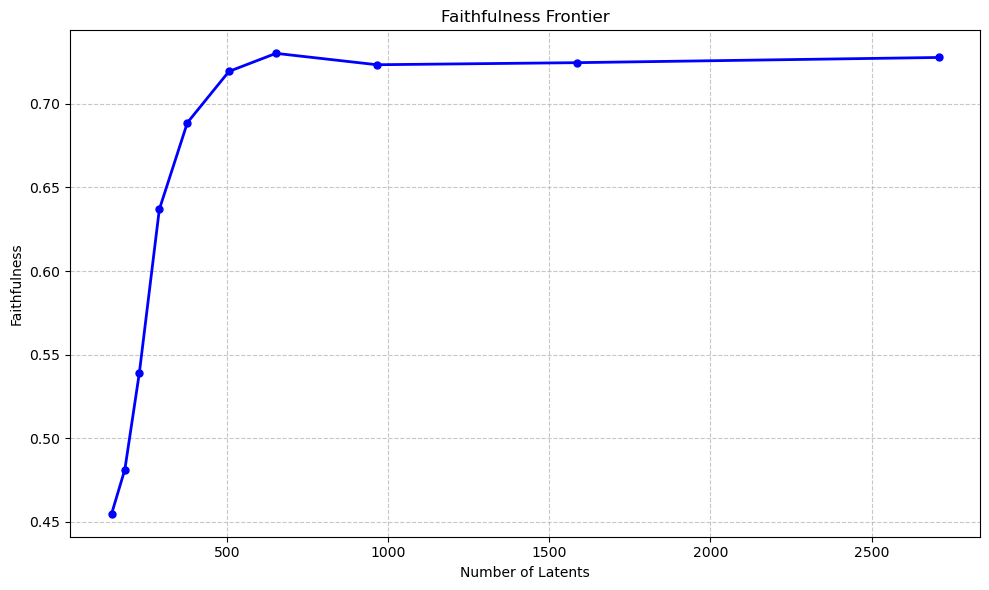

In [74]:

def plot_faithfulness_frontier(faithfulness_frontier):
    # Assuming faithfulness_frontier is your list of tuples
    # Example: faithfulness_frontier = [(10, 0.8), (20, 0.85), (30, 0.89), ...]

    # Unzip the tuples into separate lists for x and y coordinates
    num_latents, faithfulness = zip(*faithfulness_frontier)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(num_latents, faithfulness, 'b.-', linewidth=2, markersize=10)

    # Add labels and title
    plt.xlabel('Number of Latents')
    plt.ylabel('Faithfulness')
    plt.title('Faithfulness Frontier')

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Optionally, you can customize the axis ranges if needed
    # plt.xlim([min(num_latents), max(num_latents)])
    # plt.ylim([min(faithfulness), max(faithfulness)])

    # Display the plot
    plt.tight_layout()
    plt.show()
plot_faithfulness_frontier(ig_faithfulness_frontier)

In [78]:
thresholds = []
modify_fn=lambda x: x**2
start_threshold = 0.01
end_threshold = 0.2
n_runs = 5
delta = (end_threshold - start_threshold) / n_runs
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
mf = lambda x: linear_map(modify_fn(x))
for i in range(n_runs):
    thresholds.append(
        mf(start_threshold + i*delta)
        )
thresholds

[0.01,
 0.020495238095238094,
 0.04474285714285713,
 0.08274285714285712,
 0.13449523809523808]

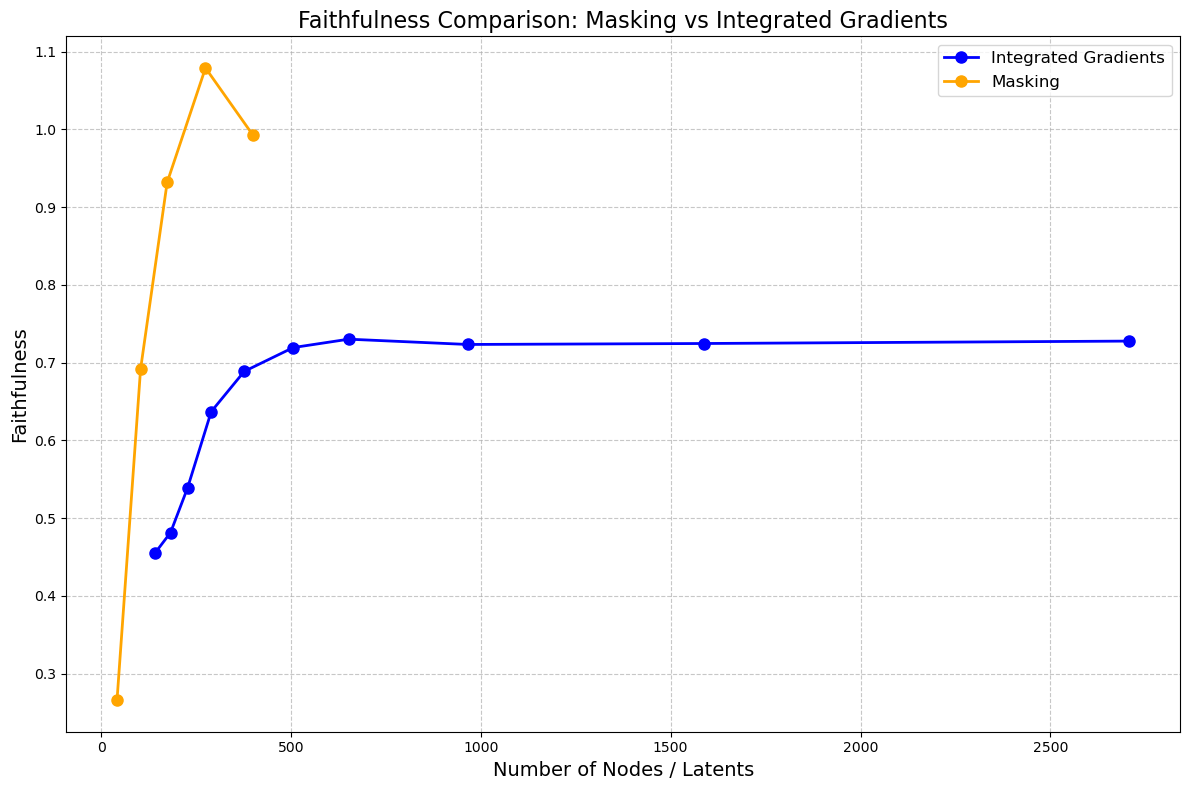

In [79]:
import matplotlib.pyplot as plt
import json
thresholds = []
modify_fn=lambda x: x**2
# thresholds = []
# modify_fn=lambda x: x**2
start_threshold = 0.01
end_threshold = 0.2
n_runs = 5
delta = (end_threshold - start_threshold) / n_runs
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
mf = lambda x: linear_map(modify_fn(x))
for i in range(n_runs):
    thresholds.append(
        mf(start_threshold + i*delta)
        )
thresholds
nnodes = []
faithfulness = []
for i in thresholds:
    sparsity_multiplier = i
    bdir = f"masks/codereason/index/len6_digit1/logit_diff_{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
    # load the dict 
    with open(bdir, 'r') as file:
        mask_dict = json.load(file)
    nnodes.append(mask_dict['total_density'])
    faithfulness.append(mask_dict['faithfulness'])


# Unzip the tuples into separate lists for Integrated Gradients plot
num_latents, ig_faithfulness = zip(*ig_faithfulness_frontier)

# Create the combined plot
plt.figure(figsize=(12, 8))

# Plot "Integrated Gradients"
plt.plot(num_latents, ig_faithfulness, marker='o',linestyle='-', linewidth=2, markersize=8,  label='Integrated Gradients', color='blue')

# Plot "Masking"
plt.plot(nnodes, faithfulness, marker='o', linestyle='-', linewidth=2, markersize=8, label='Masking', color='orange')

# Add labels, legend, and title
plt.xlabel('Number of Nodes / Latents', fontsize=14)
plt.ylabel('Faithfulness', fontsize=14)
plt.title('Faithfulness Comparison: Masking vs Integrated Gradients', fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


## overlap stuff 

In [83]:
thresholds


[0.01,
 0.020495238095238094,
 0.04474285714285713,
 0.08274285714285712,
 0.13449523809523808]

In [89]:
sparsity_multiplier = thresholds[0]
bdir = f"masks/codereason/index/len6_digit1/logit_diff_{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
sae_masks = []
example_length = 29
for i in range(4):
    sae_mask = SparseMask(saes[i].cfg.d_sae, 1.0, seq_len=example_length).to(device)
    sae_mask.load_state_dict(torch.load(f"masks/codereason/index/len6_digit1/logit_diff_{str(sparsity_multiplier)}_run/sae_mask_{i}.pt"))
    sae_masks.append(sae_mask)

/tmp/ipykernel_601139/1915346626.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae_mask.load_state_dict(torch.load(f"masks/codereason/index/len6_digit1/logit_diff_{str

In [90]:
ig_masks = []
def load_igmask(file_path):
    """Load an IGMask instance from a file."""
    state_dict = torch.load(file_path)

    # Ensure the loaded state contains the necessary components
    if 'ig_scores' not in state_dict:
        raise ValueError("The saved file does not contain the necessary components for IGMask.")

    # Recreate the IGMask instance
    igmask = IGMask(ig_scores=state_dict['ig_scores'])
    return igmask

for i in range(4):
    ig_mask = load_igmask(f"masks/ioi/baba21/igmask/igmask_{saes[i].cfg.hook_layer}.pt")
    
    #IGMask(torch.load(f"masks/ioi/baba21/igmask/igmask_{saes[i].cfg.hook_layer}.pt"))
    ig_masks.append(ig_mask)

/tmp/ipykernel_601139/460521388.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(file_path)


In [91]:
ig_thres = []
start_threshold = 0.00005
end_threshold = 0.05
steps = 10
modify_fn=lambda x: x**2
delta = (end_threshold - start_threshold) / steps
mf = lambda x: linear_map(modify_fn(x))
for i in range(steps):
    ig_thres.append(
        mf(start_threshold + i*delta)
        )
ig_thres

[5e-05,
 0.000558482017982018,
 0.0020639680319680317,
 0.004566458041958042,
 0.008065952047952048,
 0.012562450049950049,
 0.018055952047952052,
 0.02454645804195805,
 0.032033968031968035,
 0.04051848201798201]

In [99]:
ttl_ig_nodes = 0
ig_full_nodes = {}
for i in range(4):
    ig_mask_obj = ig_masks[i].get_binarized_mask(threshold=ig_thres[-5])
    ig_mask_nodes = torch.where(ig_mask_obj > 0)[1].tolist()
    ig_full_nodes[saes[i].cfg.hook_name] = ig_mask_nodes
    # len(ig_mask_nodes)
    ttl_ig_nodes += len(ig_mask_nodes)
print(ttl_ig_nodes)
ig_full_nodes

233


{'blocks.7.hook_resid_post': [2304,
  3781,
  7330,
  7386,
  8536,
  9329,
  13973,
  1392,
  1598,
  1675,
  2223,
  2304,
  2529,
  2846,
  4203,
  4276,
  4384,
  7330,
  7386,
  7844,
  9329,
  9353,
  10211,
  11558,
  13973,
  956,
  3781,
  6624],
 'blocks.14.hook_resid_post': [1156,
  1690,
  3943,
  6726,
  8059,
  10813,
  11341,
  11973,
  15625,
  30,
  1156,
  1477,
  1530,
  1822,
  3724,
  3943,
  5917,
  6601,
  6726,
  7897,
  8059,
  9006,
  9235,
  10813,
  11341,
  11973,
  12239,
  13474,
  13797,
  14632,
  15625,
  15776,
  16059,
  604,
  1448,
  3751,
  4418,
  4811,
  6191,
  8629,
  8746,
  9066,
  14778,
  15305,
  15939],
 'blocks.21.hook_resid_post': [611,
  654,
  10356,
  13526,
  13664,
  14108,
  229,
  611,
  654,
  918,
  1876,
  2003,
  2248,
  3445,
  4381,
  6066,
  6189,
  6387,
  6567,
  6911,
  7638,
  8240,
  8500,
  8842,
  8931,
  10231,
  10356,
  10986,
  11306,
  11527,
  13145,
  13216,
  13526,
  13664,
  14054,
  14108,
  14949,
  151

In [100]:
ttl_bi_nodes = 0
bi_full_nodes = {}
for i in range(4):
    bimask_nodes = torch.where(sae_masks[i].mask > 0)[1].tolist()
    bi_full_nodes[saes[i].cfg.hook_name] = bimask_nodes
    ttl_bi_nodes += len(bimask_nodes)
print(ttl_bi_nodes)
print(bi_full_nodes)

399
{'blocks.7.hook_resid_post': [1496, 6882, 197, 2498, 4958, 9843, 15880, 197, 2157, 2498, 5337, 9299, 9938, 15041, 197, 2157, 2498, 4958, 5337, 11644, 2157, 2498, 5337, 11644, 2157, 4958, 5337, 10665, 11522, 11669, 15041, 528, 4140, 4807, 4958, 5337, 8045, 8987, 10122, 10501, 10665, 11073, 11522, 11669, 12797, 14667, 15041, 15244, 15753], 'blocks.14.hook_resid_post': [9663, 534, 2038, 3021, 8734, 534, 4093, 11578, 12405, 13245, 534, 3021, 11578, 13245, 14869, 15322, 534, 11578, 13245, 15322, 3021, 4170, 11578, 12405, 13245, 501, 534, 1788, 3021, 3742, 3818, 4170, 4241, 4554, 5137, 5689, 7078, 8157, 8330, 9393, 11578, 11891, 11946, 12357, 12405, 12548, 13677, 14308, 14567, 14743, 15421, 15588], 'blocks.21.hook_resid_post': [5225, 12112, 2453, 2498, 6201, 14219, 15373, 2453, 2498, 4328, 6201, 12295, 12529, 14219, 2453, 2498, 4170, 6201, 12295, 12529, 14219, 15373, 2453, 2498, 4170, 6201, 12529, 14219, 4170, 6201, 10996, 14219, 15373, 2453, 4170, 4328, 22, 52, 613, 972, 1197, 1408, 159

In [101]:
def calculate_overlap(small_dict, big_dict):
    ious = {}
    for block, small_elements in small_dict.items():
        if block in big_dict and block.startswith("blocks"):
            unique1 = set(small_elements)
            unique2 = set(big_dict[block])
            # big_elements = big_dict[block]
            # overlap_count = len(set(small_elements) & set(big_elements))
            intersection = unique1.intersection(unique2)
            union = unique1.union(unique2)
            ious[block] = [len(intersection) / len(union), len(unique1), len(unique2), len(intersection), len(union)]
    return ious

calculate_overlap(ig_full_nodes, bi_full_nodes)

{'blocks.7.hook_resid_post': [0.0, 22, 28, 0, 50],
 'blocks.14.hook_resid_post': [0.0, 37, 34, 0, 71],
 'blocks.21.hook_resid_post': [0.0, 48, 127, 0, 175],
 'blocks.40.hook_resid_post': [0.01834862385321101, 98, 124, 4, 218]}

# data creation - Key Error 

In [24]:
# Expanding the name pool with a larger set of names
extended_name_pool = [
    "Bob", "Sam", "Lilly", "Rob", "Alice", "Charlie", "Sally", "Tom", "Jake", "Emily", 
    "Megan", "Chris", "Sophia", "James", "Oliver", "Isabella", "Mia", "Jackson", 
    "Emma", "Ava", "Lucas", "Benjamin", "Ethan", "Grace", "Olivia", "Liam", "Noah", "Diego"
]
var_name_pool = ["age", "scores", "data", "height", "weight", "grades"]
for name in extended_name_pool:
    assert len(model.tokenizer.encode(name)) == 2, f"Name {name} has more than 1 token"

for var in var_name_pool:
    assert len(model.tokenizer.encode(var)) == 2, f"Variable {var} has more than 1 token"

# Function to generate the dataset with correct and incorrect keying into dictionaries
def generate_extended_dataset(name_pool, output_path, num_samples=5, num_keys=5, digit=1):
    dataset = []
    for _ in range(num_samples):
        # Randomly select 5 names from the pool
        selected_names = random.sample(name_pool, 5)
        selected_var = random.choice(var_name_pool)
        
        # Assign random ages to the selected names
        person_dict = {name: random.randint(10**(digit-1), 10**digit - 1) for name in selected_names}
        # Create a correct example
        correct_name = random.choice(list(person_dict.keys()))
        correct_prompt = f'>>> {selected_var} = {person_dict}\n>>> {selected_var}["{correct_name}"]\n'
        correct_response = person_dict[correct_name]
        correct_token = str(correct_response)[0]
        # Create an incorrect example with a name not in the dictionary
        
        incorrect_name = random.choice([name for name in name_pool if name not in person_dict])
        if random.random()>0.5:
            # put the new name in the key.
            incorrect_prompt = f'>>> {selected_var} = {person_dict}\n>>> {selected_var}["{incorrect_name}"]\n'
        else:
            # put the new name in the dict, and swap the key.
            keys = list(person_dict.keys())
            items = list(person_dict.values())

            location = keys.index(correct_name)
            keys[location] = incorrect_name

            broken_age_dict = dict(zip(keys, items))
            incorrect_prompt = f'>>> {selected_var} = {broken_age_dict}\n>>> {selected_var}["{correct_name}"]\n'

        dataset.append({
            "clean_prefix": correct_prompt,
            "patch_prefix": incorrect_prompt,
            "clean_answer": correct_token,
            "patch_answer": "Traceback",
            "case": f"key_len{num_keys}_digit{digit}_no_err"
        })
        dataset.append({
            "clean_prefix": incorrect_prompt,
            "patch_prefix": correct_prompt,
            "clean_answer": "Traceback",
            "patch_answer": correct_token,
            "case": f"key_len{num_keys}_digit{digit}_err"
        })

    os.makedirs(output_path, exist_ok=True)
    save_path = os.path.join(output_path, f"data_len{num_keys}_digit{digit}.json")
    # Save the dataset to a JSON file
    with open(save_path, "w") as json_file:
        json.dump(dataset, json_file, indent=2)

    # Display confirmation
    print(f"Dataset saved to {save_path}")

    # return dataset
# Generate the extended dataset
dpath = "data/codereason/key/"
generate_extended_dataset(extended_name_pool, dpath, num_samples=10000, num_keys=5)
# json_dataset

Dataset saved to data/codereason/key/data_len5_digit1.json


In [12]:
from transformer_lens.utils import test_prompt
test_prompt(json_dataset[0]['error']['prompt'], "9", model, prepend_space_to_answer=False)

Tokenized prompt: ['<bos>', '>>>', ' weight', ' =', " {'", 'Benjamin', "':", ' ', '4', ',', " '", 'Isabella', "':", ' ', '6', ',', " '", 'James', "':", ' ', '4', ',', " '", 'Emily', "':", ' ', '9', ',', " '", 'Mia', "':", ' ', '2', '}', '\n', '>>>', ' weight', '["', 'Ethan', '"]', '\n']
Tokenized answer: ['9']


Performance on answer token:
Rank: 19       Logit: 19.07 Prob:  0.18% Token: |9|

Top 0th token. Logit: 24.92 Prob: 63.66% Token: |Traceback|
Top 1th token. Logit: 23.51 Prob: 15.62% Token: |>>>|
Top 2th token. Logit: 21.93 Prob:  3.21% Token: |None|
Top 3th token. Logit: 21.75 Prob:  2.69% Token: |Name|
Top 4th token. Logit: 21.55 Prob:  2.19% Token: |0|
Top 5th token. Logit: 21.28 Prob:  1.67% Token: |4|
Top 6th token. Logit: 21.10 Prob:  1.40% Token: |Key|
Top 7th token. Logit: 20.60 Prob:  0.85% Token: |'|
Top 8th token. Logit: 20.49 Prob:  0.76% Token: |1|
Top 9th token. Logit: 20.33 Prob:  0.65% Token: |<eos>|


Ranks of the answer tokens: [('9', 19)]

In [25]:
import json
N = 5
K = 1
file_path = f'data/codereason/key/data_len{N}_digit{K}.json'
with open(file_path, 'r') as file:
    data = json.load(file)
data[0]

{'clean_prefix': '>>> weight = {\'Bob\': 9, \'Diego\': 6, \'Rob\': 5, \'James\': 2, \'Jackson\': 1}\n>>> weight["Diego"]\n',
 'patch_prefix': '>>> weight = {\'Bob\': 9, \'Diego\': 6, \'Rob\': 5, \'James\': 2, \'Jackson\': 1}\n>>> weight["Tom"]\n',
 'clean_answer': '6',
 'patch_answer': 'Traceback',
 'case': 'key_len5_digit1_no_err'}

In [29]:
len(model.tokenizer(data[1]['clean_prefix']).input_ids)

41

In [28]:
len(model.tokenizer(data[1]['patch_prefix']).input_ids)

41

In [30]:
clean_data = []
corr_data = []
clean_labels = []
corr_labels = []
for entry in data:
    clean_len = len(model.tokenizer(entry['clean_prefix']).input_ids)
    corr_len = len(model.tokenizer(entry['patch_prefix']).input_ids)
    if clean_len == corr_len == 41:
        clean_data.append(entry['clean_prefix'])
        corr_data.append(entry['patch_prefix'])
        clean_labels.append(entry['clean_answer'])
        corr_labels.append(entry['patch_answer'])
print(len(clean_data))

20000


In [31]:
N = 3000
clean_tokens = model.to_tokens(clean_data[:N])
corr_tokens = model.to_tokens(corr_data[:N])
clean_label_tokens = model.to_tokens(clean_labels[:N], prepend_bos=False).squeeze(-1)
corr_label_tokens = model.to_tokens(corr_labels[:N], prepend_bos=False).squeeze(-1)
print(clean_tokens.shape, corr_tokens.shape)

def logit_diff_fn(logits, clean_labels, corr_labels, token_wise=False):
    clean_logits = logits[torch.arange(logits.shape[0]), -1, clean_labels]
    corr_logits = logits[torch.arange(logits.shape[0]), -1, corr_labels]
    return (clean_logits - corr_logits).mean() if not token_wise else (clean_logits - corr_logits)

batch_size = 16 
clean_tokens = clean_tokens[:batch_size*(len(clean_tokens)//batch_size)]
corr_tokens = corr_tokens[:batch_size*(len(corr_tokens)//batch_size)]
clean_label_tokens = clean_label_tokens[:batch_size*(len(clean_label_tokens)//batch_size)]
corr_label_tokens = corr_label_tokens[:batch_size*(len(corr_label_tokens)//batch_size)]

clean_tokens = clean_tokens.reshape(-1, batch_size, clean_tokens.shape[-1])
corr_tokens = corr_tokens.reshape(-1, batch_size, corr_tokens.shape[-1])
clean_label_tokens = clean_label_tokens.reshape(-1, batch_size)
corr_label_tokens = corr_label_tokens.reshape(-1, batch_size)

print(clean_tokens.shape, corr_tokens.shape, clean_label_tokens.shape, corr_label_tokens.shape)

torch.Size([3000, 41]) torch.Size([3000, 41])
torch.Size([187, 16, 41]) torch.Size([187, 16, 41]) torch.Size([187, 16]) torch.Size([187, 16])


In [32]:
example_length = 41

In [36]:
use_mask = False 
mean_mask = False
avg_logit_diff = 0
cleanup_cuda()
with torch.no_grad():
    for i in range(10):
        logits = model.run_with_hooks(
            clean_tokens[i], 
            return_type="logits", 
            fwd_hooks=build_hooks_list(clean_tokens[i], use_mask=use_mask, mean_mask=mean_mask)
            )
        ld = logit_diff_fn(logits, clean_label_tokens[i], corr_label_tokens[i])
        print(ld)
        avg_logit_diff += ld
        del logits
        cleanup_cuda()
avg_logit_diff = (avg_logit_diff / 10).item()
print("Average LD: ", avg_logit_diff)

tensor(5.0600, device='cuda:0')
tensor(4.3833, device='cuda:0')
tensor(4.8820, device='cuda:0')
tensor(4.8589, device='cuda:0')
tensor(4.5987, device='cuda:0')
tensor(4.8964, device='cuda:0')
tensor(4.6313, device='cuda:0')
tensor(4.9902, device='cuda:0')
tensor(4.8940, device='cuda:0')
tensor(5.2038, device='cuda:0')
Average LD:  4.839864253997803


In [37]:
for sae in saes:
    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length).to(device)
    
def running_mean_tensor(old_mean, new_value, n):
    return old_mean + (new_value - old_mean) / n

def get_sae_means(mean_tokens, total_batches, batch_size, per_token_mask=False):
    for sae in saes:
        sae.mean_ablation = torch.zeros(sae.cfg.d_sae).float().to(device)
    
    with tqdm(total=total_batches*batch_size, desc="Mean Accum Progress") as pbar:
        for i in range(total_batches):
            for j in range(batch_size):
                with torch.no_grad():
                    _ = model.run_with_hooks(
                        mean_tokens[i, j], 
                        return_type="logits", 
                        fwd_hooks=build_hooks_list(mean_tokens[i, j], cache_sae_activations=True)
                        )
                    for sae in saes:
                        sae.mean_ablation = running_mean_tensor(sae.mean_ablation, sae.feature_acts, i+1)
                    cleanup_cuda()
                pbar.update(1)

            if i >= total_batches:
                break

get_sae_means(corr_tokens, 25, 16)

Mean Accum Progress: 100%|██████████| 400/400 [01:50<00:00,  3.63it/s]


In [38]:
avg_mean_diff = 0
with torch.no_grad():
    for i in range(5):
        logits = model.run_with_hooks(
            clean_tokens[i], 
            return_type="logits", 
            fwd_hooks=build_hooks_list(clean_tokens[i], mean_ablate=True)
            )
        ld = logit_diff_fn(logits, clean_label_tokens[i], corr_label_tokens[i])
        print(ld)
        avg_mean_diff += ld
        del logits
        cleanup_cuda()
print("Average LD: ", avg_mean_diff)

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
Average LD:  tensor(0., device='cuda:0')


## Mask training

In [39]:
import torch.nn.functional as F
import wandb
import signal
class KeyboardInterruptBlocker:
    def __enter__(self):
        # Block SIGINT and store old mask
        self.old_mask = signal.pthread_sigmask(signal.SIG_BLOCK, {signal.SIGINT})

    def __exit__(self, exc_type, exc_value, traceback):
        # Restore old mask (unblock SIGINT)
        signal.pthread_sigmask(signal.SIG_SETMASK, self.old_mask)

class Range:
    def __init__(self, *args):
        # Support for range(start, stop, step) or range(stop)
        self.args = args

        # Validate input like the built-in range does
        if len(self.args) not in {1, 2, 3}:
            raise TypeError(f"Range expected at most 3 arguments, got {len(self.args)}")
        
        self.range = __builtins__.range(*self.args)  # Create the range object

    def __iter__(self):
        for i in self.range:
            try:
                with KeyboardInterruptBlocker():
                    yield i
            except KeyboardInterrupt:
                print("Keyboard interrupt received. Exiting iteration.")
                break

    def __len__(self):
        return len(self.range)

In [40]:
def do_training_run(token_dataset, labels_dataset, corr_labels_dataset, sparsity_multiplier, task, example_length=6, loss_function='ce', per_token_mask=False, use_mask=True, mean_mask=False, portion_of_data = 0.5, distinct_sparsity_multiplier=0 ):

    def logitfn(tokens, use_mask, mean_mask):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask)
            )
        return logits

    def forward_pass(batch, clean_label_tokens, corr_label_tokens, logitfn, ratio_trained=1, loss_function='ce'):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens, use_mask, mean_mask)
        model_logits = logitfn(tokens, False, False)
        last_token_logits = logits[:, -1, :]
        if loss_function == 'ce':
            loss = F.cross_entropy(last_token_logits, clean_label_tokens)
        elif loss_function == 'logit_diff':
            fwd_logit_diff = logit_diff_fn(logits, clean_label_tokens, corr_label_tokens)
            model_logit_diff = logit_diff_fn(model_logits, clean_label_tokens, corr_label_tokens)
            loss = torch.abs(model_logit_diff - fwd_logit_diff)
        
        del model_logits, logits
        cleanup_cuda()

        sparsity_loss = 0
        distinct_sparsity_loss = 0
        # if per_token_mask:
        #     distinct_sparsity_loss = 0
        for sae in saes:
            sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
            # if per_token_mask:
            #     distinct_sparsity_loss = distinct_sparsity_loss + sae.mask.distinct_sparsity_loss
        
        sparsity_loss = sparsity_loss / len(saes)
        distinct_sparsity_loss = distinct_sparsity_loss / len(saes)

        return loss, sparsity_loss, distinct_sparsity_loss

    print("doing a run with sparsity multiplier", sparsity_multiplier)
    all_optimized_params = []
    config = {
        "batch_size": 16,
        "learning_rate": 1,
        "total_steps": token_dataset.shape[0]*portion_of_data,
        "sparsity_multiplier": sparsity_multiplier
    }

    for sae in saes:
        if per_token_mask:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length).to(device)
        else:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0).to(device)
        all_optimized_params.extend(list(sae.mask.parameters()))
        sae.mask.max_temp = torch.tensor(200.0)
    
    wandb.init(project="sae circuits", config=config)
    optimizer = optim.Adam(all_optimized_params, lr=config["learning_rate"])
    total_steps = config["total_steps"] #*20 #*config["batch_size"]
    # epochs = 20
    with tqdm(total=total_steps*1.1, desc="Training Progress") as pbar:
        # for epoch in range(epochs):
        for i, (x, y, z) in enumerate(zip(token_dataset, labels_dataset, corr_labels_dataset)):
            with KeyboardInterruptBlocker():
                optimizer.zero_grad()
                
                # Calculate ratio trained
                ratio_trained =  i / total_steps*1.1
                
                # Update mask ratio for each SAE
                for sae in saes:
                    sae.mask.ratio_trained = ratio_trained
                
                # Forward pass with updated ratio_trained
                loss, sparsity_loss, _ = forward_pass(x, y, z, logitfn, ratio_trained=ratio_trained, loss_function=loss_function)
                # if per_token_mask:
                #     sparsity_loss = sparsity_loss / example_length
                # print("sp loss", sparsity_loss)
                # print("sae 0 sp loss", saes[0].mask.sparsity_loss)
                # print("sae 1 sp loss", saes[1].mask.sparsity_loss)
                # print("sae 2 sp loss", saes[2].mask.sparsity_loss)
                # print("sae 3 sp loss", saes[3].mask.sparsity_loss)
                
                avg_nonzero_elements = sparsity_loss
                # avg_distinct_nonzero_elements = distinct_sparsity_loss
                    
                sparsity_loss = sparsity_loss * config["sparsity_multiplier"] #+ distinct_sparsity_loss * distinct_sparsity_multiplier
                total_loss = sparsity_loss + loss
                infodict  = {"Step": i, "Progress": ratio_trained, "Avg Nonzero Elements": avg_nonzero_elements.item(), "Task Loss": loss.item(), "Sparsity Loss": sparsity_loss.item(), "temperature": saes[0].mask.temperature} # "avg distinct lat/sae":avg_distinct_nonzero_elements.item()
                wandb.log(infodict)
                # break
                # Backward pass and optimizer step
                total_loss.backward()
                optimizer.step()
                
                # Update tqdm bar with relevant metrics
                pbar.set_postfix(infodict)
                
                # Update the tqdm progress bar
                pbar.update(1)
                # break
                if i >= total_steps*1.1:
                    break
    wandb.finish()

    optimizer.zero_grad()

    for sae in saes:
        for param in sae.parameters():
            param.grad = None
        for param in sae.mask.parameters():
            param.grad = None
    
    for param in model.parameters():
        param.grad = None

    torch.cuda.empty_cache()

    ### EVAL ###
    def masked_logit_fn(tokens):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask, binarize_mask=True)
            )
        return logits

    def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens)
        last_token_logits = logits[:, -1, :]
        loss = F.cross_entropy(last_token_logits, labels)
        return loss
    
    def eval_logit_diff(num_batches, batch, clean_labels, corr_labels, logitfn, ratio_trained=10):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        avg_ld = 0
        for i in range(num_batches):
            tokens = batch[-i]
            logits = logitfn(tokens)
            ld = logit_diff_fn(logits, clean_labels[-i], corr_labels[-i])
            avg_ld += ld
            del logits
            cleanup_cuda()
        return (avg_ld / num_batches).item()

    with torch.no_grad():
        loss = eval_ce_loss(token_dataset[-1], labels_dataset[-1], masked_logit_fn)
        print("CE loss:", loss)
        cleanup_cuda()
        logit_diff = eval_logit_diff(10, token_dataset, labels_dataset, corr_labels_dataset, masked_logit_fn)
        print("Logit Diff:", logit_diff)
        cleanup_cuda()
    
    mask_dict = {}

    total_density = 0
    for sae in saes:
        mask_dict[sae.cfg.hook_name] = torch.where(sae.mask.mask > 0)[1].tolist()   # rob thinks .view(-1) needed here
        total_density += (sae.mask.mask > 0).sum().item()
    mask_dict["total_density"] = total_density
    mask_dict['avg_density'] = total_density / len(saes)

    if per_token_mask:
        print("total # latents in circuit: ", total_density)
    print("avg density", mask_dict['avg_density'])

    save_path = f"masks/{task}/{loss_function}_{str(sparsity_multiplier)}_run/"
    os.makedirs(save_path, exist_ok=True)
    mask_dict['ce_loss'] = loss.item()
    mask_dict['logit_diff'] = logit_diff
    faithfulness = logit_diff / avg_logit_diff
    mask_dict['faithfulness'] = faithfulness
    
    for idx, sae in enumerate(saes):
        mask_path = f"sae_mask_{idx}.pt"
        torch.save(sae.mask.state_dict(), os.path.join(save_path,mask_path))
        print(f"Saved mask for SAE {idx} to {mask_path}")

    json.dump(mask_dict, open(os.path.join(save_path,f"{str(sparsity_multiplier)}_run.json"), "w"))

In [42]:
do_training_run(token_dataset=clean_tokens, labels_dataset= clean_label_tokens, corr_labels_dataset=corr_label_tokens, sparsity_multiplier=0.5, task=f'codereason/key/len5_digit1', example_length=example_length, loss_function="logit_diff", per_token_mask=True, use_mask=True, mean_mask=True, portion_of_data=0.4)

doing a run with sparsity multiplier 0.5


Training Progress: 84it [04:40,  3.34s/it, Step=83, Progress=1.22, Avg Nonzero Elements=0.5, Task Loss=5.01, Sparsity Loss=0.25, temperature=tensor(643.5912)]                                


Avg Nonzero Elements,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Sparsity Loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Task Loss,▁▇▇▇▇▇▇▆▇█▇▆▇▇▆▆▆▆▇▇▇▆▇▇█▇▇██▇█▇▇██▇▇▇█▇
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▄▄▄▅▆▇█
Avg Nonzero Elements,0.5
Progress,1.22059
Sparsity Loss,0.25
Step,83
Task Loss,5.0064


CE loss: tensor(4.0406, device='cuda:0')
Logit Diff: 0.0
total # latents in circuit:  2
avg density 0.5
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt


In [43]:
thresholds = []
modify_fn=lambda x: x**2
start_threshold = 0.01
end_threshold = 0.2
n_runs = 5
delta = (end_threshold - start_threshold) / n_runs
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
mf = lambda x: linear_map(modify_fn(x))
for i in range(n_runs):
    thresholds.append(
        mf(start_threshold + i*delta)
        )
thresholds

[0.01,
 0.020495238095238094,
 0.04474285714285713,
 0.08274285714285712,
 0.13449523809523808]

In [44]:
for i in thresholds[1:]:
    do_training_run(token_dataset=clean_tokens, labels_dataset= clean_label_tokens, corr_labels_dataset=corr_label_tokens, sparsity_multiplier=i, task=f'codereason/key/len5_digit1', example_length=example_length, loss_function="logit_diff", per_token_mask=True, use_mask=True, mean_mask=True, portion_of_data=0.3)

doing a run with sparsity multiplier 0.020495238095238094


Training Progress:  99%|█████████▉| 61/61.71000000000001 [03:27<00:02,  3.34s/it, Step=61, Progress=1.2, Avg Nonzero Elements=73.8, Task Loss=0.0432, Sparsity Loss=1.51, temperature=tensor(565.2133)]   /home/jnainani_umass_edu/.conda/envs/finetuning/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Training Progress: 63it [03:30,  3.35s/it, Step=62, Progress=1.22, Avg Nonzero Elements=73.8, Task Loss=0.0147, Sparsity Loss=1.51, temperature=tensor(627.0910)]                                       


Avg Nonzero Elements,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Sparsity Loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Task Loss,█▆▄▂▁▂▂▃▂▁▁▁▁▁▁▂▄▁▁▂▂▁▁▂▁▁▂▂▁▂▂▂▁▁▃▂▄▂▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▅▆▆▇█
Avg Nonzero Elements,73.75
Progress,1.21569
Sparsity Loss,1.51152
Step,62
Task Loss,0.01469


CE loss: tensor(2.1658, device='cuda:0')
Logit Diff: 5.004411220550537
total # latents in circuit:  295
avg density 73.75
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.04474285714285713


Training Progress:  99%|█████████▉| 61/61.71000000000001 [03:27<00:02,  3.34s/it, Step=61, Progress=1.2, Avg Nonzero Elements=45.8, Task Loss=0.882, Sparsity Loss=2.05, temperature=tensor(565.2133)]    /home/jnainani_umass_edu/.conda/envs/finetuning/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Training Progress: 63it [03:30,  3.34s/it, Step=62, Progress=1.22, Avg Nonzero Elements=45.8, Task Loss=1.09, Sparsity Loss=2.05, temperature=tensor(627.0910)]                                       


Avg Nonzero Elements,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Sparsity Loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Task Loss,▇█▇▇▄▄▄▁▄▃▄▃▃▄▃▄▄▃▂▂▂▃▂▂▄▃▄▂▃▂▄▄▅▄▂▁▄▂▃▃
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▅▆▆▇█
Avg Nonzero Elements,45.75
Progress,1.21569
Sparsity Loss,2.04699
Step,62
Task Loss,1.0862


CE loss: tensor(2.3046, device='cuda:0')
Logit Diff: 4.265265464782715
total # latents in circuit:  183
avg density 45.75
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.08274285714285712


Training Progress:  99%|█████████▉| 61/61.71000000000001 [03:28<00:02,  3.34s/it, Step=61, Progress=1.2, Avg Nonzero Elements=19.8, Task Loss=2.8, Sparsity Loss=1.63, temperature=tensor(565.2133)]      /home/jnainani_umass_edu/.conda/envs/finetuning/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Training Progress: 63it [03:31,  3.36s/it, Step=62, Progress=1.22, Avg Nonzero Elements=19.8, Task Loss=2.69, Sparsity Loss=1.63, temperature=tensor(627.0910)]                                       


Avg Nonzero Elements,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Sparsity Loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Task Loss,▁▅█▆▆▆▆▃▄▃▃▄▄▅▄▄▅▄▃▃▃▄▃▃▃▄▄▄▃▅▅▄▅▄▂▃▅▃▄▄
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▅▆▆▇█
Avg Nonzero Elements,19.75
Progress,1.21569
Sparsity Loss,1.63417
Step,62
Task Loss,2.69111


CE loss: tensor(2.8741, device='cuda:0')
Logit Diff: 2.3407113552093506
total # latents in circuit:  79
avg density 19.75
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt
doing a run with sparsity multiplier 0.13449523809523808


Training Progress:  99%|█████████▉| 61/61.71000000000001 [03:27<00:02,  3.34s/it, Step=61, Progress=1.2, Avg Nonzero Elements=11, Task Loss=3.88, Sparsity Loss=1.48, temperature=tensor(565.2133)]       /home/jnainani_umass_edu/.conda/envs/finetuning/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Training Progress: 63it [03:30,  3.34s/it, Step=62, Progress=1.22, Avg Nonzero Elements=11, Task Loss=3.74, Sparsity Loss=1.48, temperature=tensor(627.0910)]                                       


Avg Nonzero Elements,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Sparsity Loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Task Loss,▁▄█▇▇██▇▇▅▆▆▆▇▆▆▇▆▆▇▅▆▆▆▇▆▇▆▆▇▇▇▇▇▇▆▇▆▆▇
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▅▆▆▇█
Avg Nonzero Elements,11.0
Progress,1.21569
Sparsity Loss,1.47945
Step,62
Task Loss,3.73897


CE loss: tensor(3.5776, device='cuda:0')
Logit Diff: 0.9293985366821289
total # latents in circuit:  44
avg density 11.0
Saved mask for SAE 0 to sae_mask_0.pt
Saved mask for SAE 1 to sae_mask_1.pt
Saved mask for SAE 2 to sae_mask_2.pt
Saved mask for SAE 3 to sae_mask_3.pt


In [45]:
import torch.nn.functional as F
def get_ig_effect_batch(sae_id, token_dataset, corr_token_dataset, labels_dataset, corr_labels_dataset):
    # ig_batch_size = 4

    def logitfn_cache(tokens):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask, cache_sae_activations=True)
            )
        cached_activations = [sae.feature_acts for sae in saes]
        return logits, cached_activations
    
    # cache_sae_logitfn = build_sae_logitfn(cache_sae_activations=True)

    # def cache_sae_activations(tokens):
    #     logits = cache_sae_logitfn(tokens)
    #     cached_activations = [sae.feature_acts for sae in saes]
    #     return logits, cached_activations
    # def build_sae_logitfn(**kwargs):
    # def logitfn(tokens):
    #     return model.run_with_hooks(
    #         tokens, 
    #         return_type="logits", 
    #         fwd_hooks=build_hooks_list(tokens, **kwargs)
    #         )
    # return logitfn

    def sae_continue_cache_logitfn(tokens, sae_idx, cache, **kwargs):
        logits = model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, fake_activations=(sae_idx, cache),**kwargs)
            )
        # logitfn = build_sae_logitfn(fake_activations=(sae_idx, cache), **kwargs)
        return logits

    # correct_tokenized = batch.correct_tokenized
    # traceback_tokenized = batch.error_tokenized
    # correct_labels = batch.correct_labels
    # traceback_labels = batch.error_labels

    # run a forward pass on the correct and error examples
    with torch.no_grad():
        _, clean_activations = logitfn_cache(token_dataset)
        _, corr_activations = logitfn_cache(corr_token_dataset)


    sae = saes[sae_id]
    sae_clean_acts = clean_activations[sae_id]
    sae_corr_acts = corr_activations[sae_id]

    steps = 10
    ratios = [i/steps for i in range(steps)] # we skip the last one b/c we are integrating, obv
        
    effects = []
    for ratio in ratios:
        interpolation = (sae_clean_acts * (1-ratio) + sae_corr_acts * (ratio)).requires_grad_(True)
        interpolation.retain_grad()
        interpolated_out = sae_continue_cache_logitfn(
            token_dataset, sae.cfg.hook_layer, interpolation,
        )
        answer_logits = interpolated_out[..., -1, :] # get the logits of the last tokens
        # get the logprob on the inner most dimension
        answer_logprobs = F.log_softmax(answer_logits, dim=-1)

        clean_logprobs = answer_logprobs[..., torch.arange(answer_logprobs.shape[-2]), labels_dataset]
        corr_logprobs = answer_logprobs[..., torch.arange(answer_logprobs.shape[-2]), corr_labels_dataset]
        metric = torch.sum(clean_logprobs - corr_logprobs)
        metric.backward()

        counterfactual_delta = sae_clean_acts - sae_corr_acts
        
        effect = (interpolation.grad * counterfactual_delta).mean(dim=0)

        effects.append(effect)

    effects = torch.stack(effects)
    clear_memory()
    return effects.mean(dim=0)

def get_sae_ig_effect(sae_id, num_batches, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens):
    effect_batches = []
    for i in tqdm(range(0, num_batches)):
        clean_batch = clean_tokens[i]  
        corr_batch = corr_tokens[i]
        clean_label_batch = clean_label_tokens[i]
        corr_label_batch = corr_label_tokens[i]
        effect_batches.append(get_ig_effect_batch(sae_id, clean_batch, corr_batch, clean_label_batch, corr_label_batch))
    return torch.stack(effect_batches).mean(dim=0)

def get_all_sae_ig_effects(num_batches, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens):
    for i in range(len(saes)):
        ig_effect = get_sae_ig_effect(i, num_batches, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens)
        saes[i].igmask = IGMask(ig_effect)

In [46]:
get_all_sae_ig_effects(25, clean_tokens, corr_tokens, clean_label_tokens, corr_label_tokens)

100%|██████████| 25/25 [07:19<00:00, 17.59s/it]


In [47]:
torch.count_nonzero(saes[1].igmask.ig_scores)

tensor(9947, device='cuda:0')

In [48]:
def save_igmask(igmask, file_path):
    """Save the IGMask instance to a file."""
    if not isinstance(igmask, IGMask):
        raise ValueError("The object to save must be an instance of IGMask.")

    # Save the ig_scores and any additional parameters if needed
    state_dict = {
        'ig_scores': igmask.ig_scores
    }
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Save the state dictionary using PyTorch
    torch.save(state_dict, file_path)

for sae in saes:
    save_igmask(sae.igmask, f"masks/codereason/key/len5_digit1/igmask/igmask_{sae.cfg.hook_layer}.pt")

In [49]:
masks = produce_ig_binary_masks(threshold=0.01)
masks.print_mask_statistics()

Statistics for mask 'blocks.7.hook_resid_post':
  - Shape: [41, 16384]
  - Total latents: 671744
  - Latents ON (mask=1): 22
  - Average ON per token: 0.5366

Statistics for mask 'blocks.14.hook_resid_post':
  - Shape: [41, 16384]
  - Total latents: 671744
  - Latents ON (mask=1): 77
  - Average ON per token: 1.8780

Statistics for mask 'blocks.21.hook_resid_post':
  - Shape: [41, 16384]
  - Total latents: 671744
  - Latents ON (mask=1): 266
  - Average ON per token: 6.4878

Statistics for mask 'blocks.40.hook_resid_post':
  - Shape: [41, 16384]
  - Total latents: 671744
  - Latents ON (mask=1): 156
  - Average ON per token: 3.8049



In [50]:
def pp(x):
    keys = list(x.keys())
    values = list(x.values())
    for i in range(len(keys)):
        print(f"{keys[i]}: {values[i]}")

In [53]:
threshold = 0.00001
sum = 0
for sae in saes:
    print("layer:", sae.cfg.hook_layer)
    latents_in_sae = sae.igmask.get_threshold_info(threshold)['total_latents'].item()
    sum += latents_in_sae
    print(latents_in_sae)

print("total", sum)

print("="*40)
with torch.no_grad():
    ig_logits = model.run_with_hooks(
            clean_tokens[-1], 
            return_type="logits", 
            fwd_hooks=build_hooks_list(clean_tokens[-1], ig_mask_threshold=threshold, mean_mask=True)
            )
    ld = logit_diff_fn(ig_logits, clean_label_tokens[-1], corr_label_tokens[-1])
    print(ld)

layer: 7
6786.0
layer: 14
4687.0
layer: 21
7560.0
layer: 40
1129.0
total 20162.0
tensor(3.3223, device='cuda:0')


In [54]:
# Comparison:

def get_faithfulness(clean_tokens, clean_label_tokens, corr_label_tokens, mask, modelsae_ld):
    avg_ig_ld = 0
    with torch.no_grad():
        for i in range(10):
            ig_logits = model.run_with_hooks(
                    clean_tokens[-i], 
                    return_type="logits", 
                    fwd_hooks=build_hooks_list(clean_tokens[-i], circuit_mask=mask, mean_mask=True)
                    )
            ld = logit_diff_fn(ig_logits, clean_label_tokens[-i], corr_label_tokens[-i])
            avg_ig_ld += ld
            del ig_logits
            cleanup_cuda()
    avg_ig = (avg_ig_ld / 10).item()
    faithfulness_ratio = avg_ig/modelsae_ld
    return faithfulness_ratio

def get_faithfulness_frontier(mask_producer_fn, start_threshold, end_threshold, clean_tokens, clean_label_tokens, corr_label_tokens, modelsae_ld, steps = 10, modify_fn = lambda x: x):
    thresholds = []
    delta = (end_threshold - start_threshold) / steps

    # apply a linear function such that the linear_map(modify_fn(start_threshold)) = start_threshold
    # and linear_map(modify_fn(end_threshold)) = end_threshold

    def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
    mf = lambda x: linear_map(modify_fn(x))
    


    for i in range(steps):
        thresholds.append(
            mf(start_threshold + i*delta)
            )
    
    faithfulness_scores = []
    for threshold in tqdm(thresholds):
        mask = mask_producer_fn(threshold=threshold)
        num_latents = mask.get_num_latents()
        faithfulness_ratio = get_faithfulness(clean_tokens, clean_label_tokens, corr_label_tokens, mask, modelsae_ld
        )
        faithfulness_scores.append([num_latents, faithfulness_ratio])
    return faithfulness_scores        

ig_faithfulness_frontier = get_faithfulness_frontier(produce_ig_binary_masks, 0.00005, 0.05, clean_tokens, clean_label_tokens, corr_label_tokens, avg_logit_diff, steps=10, modify_fn=lambda x: x**2)


100%|██████████| 10/10 [01:40<00:00, 10.06s/it]


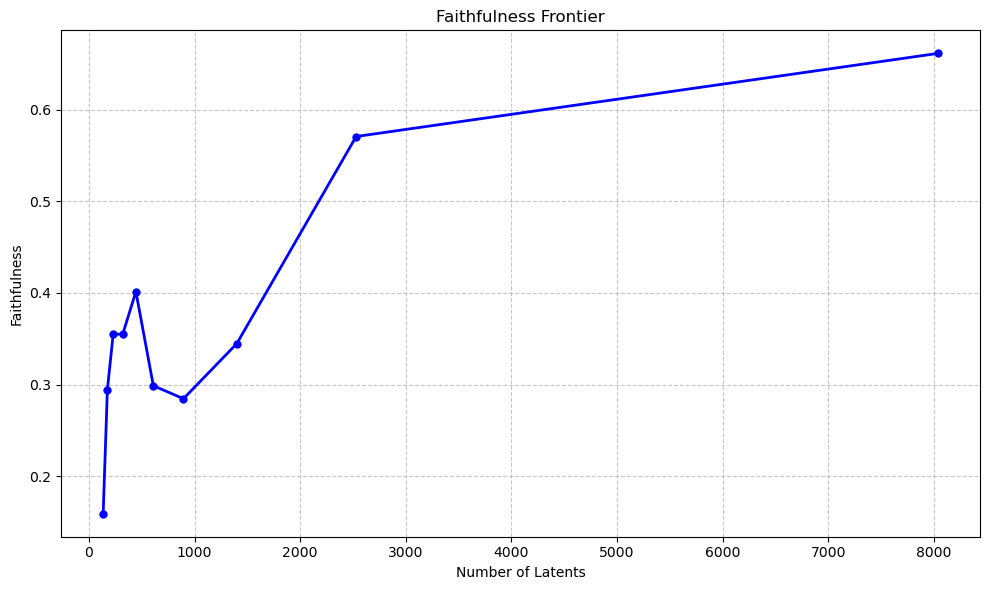

In [55]:

def plot_faithfulness_frontier(faithfulness_frontier):
    # Assuming faithfulness_frontier is your list of tuples
    # Example: faithfulness_frontier = [(10, 0.8), (20, 0.85), (30, 0.89), ...]

    # Unzip the tuples into separate lists for x and y coordinates
    num_latents, faithfulness = zip(*faithfulness_frontier)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(num_latents, faithfulness, 'b.-', linewidth=2, markersize=10)

    # Add labels and title
    plt.xlabel('Number of Latents')
    plt.ylabel('Faithfulness')
    plt.title('Faithfulness Frontier')

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Optionally, you can customize the axis ranges if needed
    # plt.xlim([min(num_latents), max(num_latents)])
    # plt.ylim([min(faithfulness), max(faithfulness)])

    # Display the plot
    plt.tight_layout()
    plt.show()
plot_faithfulness_frontier(ig_faithfulness_frontier)

In [56]:
thresholds = []
modify_fn=lambda x: x**2
start_threshold = 0.01
end_threshold = 0.2
n_runs = 5
delta = (end_threshold - start_threshold) / n_runs
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
mf = lambda x: linear_map(modify_fn(x))
for i in range(n_runs):
    thresholds.append(
        mf(start_threshold + i*delta)
        )
thresholds

[0.01,
 0.020495238095238094,
 0.04474285714285713,
 0.08274285714285712,
 0.13449523809523808]

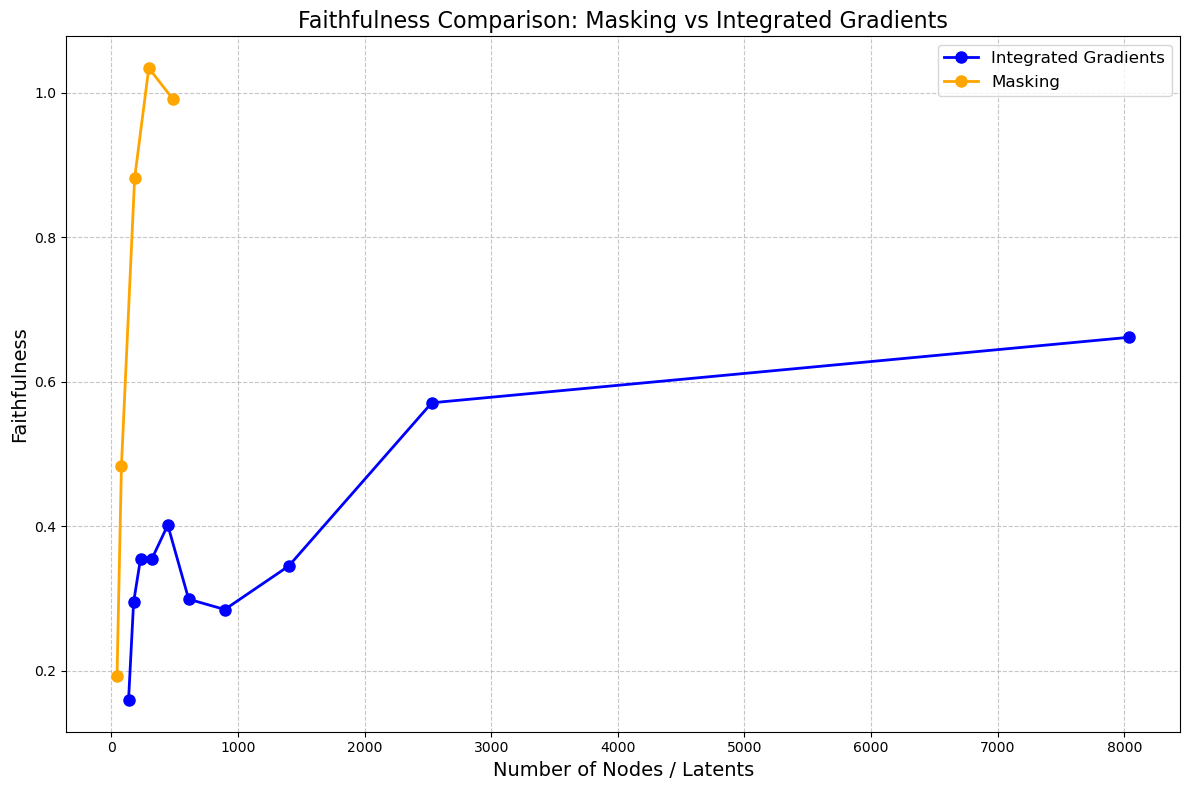

In [57]:
import matplotlib.pyplot as plt
import json
thresholds = []
modify_fn=lambda x: x**2
# thresholds = []
# modify_fn=lambda x: x**2
start_threshold = 0.01
end_threshold = 0.2
n_runs = 5
delta = (end_threshold - start_threshold) / n_runs
def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
mf = lambda x: linear_map(modify_fn(x))
for i in range(n_runs):
    thresholds.append(
        mf(start_threshold + i*delta)
        )
thresholds
nnodes = []
faithfulness = []
for i in thresholds:
    sparsity_multiplier = i
    bdir = f"masks/codereason/key/len5_digit1/logit_diff_{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
    # load the dict 
    with open(bdir, 'r') as file:
        mask_dict = json.load(file)
    nnodes.append(mask_dict['total_density'])
    faithfulness.append(mask_dict['faithfulness'])


# Unzip the tuples into separate lists for Integrated Gradients plot
num_latents, ig_faithfulness = zip(*ig_faithfulness_frontier)

# Create the combined plot
plt.figure(figsize=(12, 8))

# Plot "Integrated Gradients"
plt.plot(num_latents, ig_faithfulness, marker='o',linestyle='-', linewidth=2, markersize=8,  label='Integrated Gradients', color='blue')

# Plot "Masking"
plt.plot(nnodes, faithfulness, marker='o', linestyle='-', linewidth=2, markersize=8, label='Masking', color='orange')

# Add labels, legend, and title
plt.xlabel('Number of Nodes / Latents', fontsize=14)
plt.ylabel('Faithfulness', fontsize=14)
plt.title('Faithfulness Comparison: Masking vs Integrated Gradients', fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


## completeness

In [87]:
for sae in saes:
    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length, distinct_l1=1.0).to(device)

def eval_logit_diff(batch, clean_labels, corr_labels, ratio_trained=10):
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    logits = model.run_with_hooks(
        batch, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(batch, use_mask=True, mean_mask=True, binarize_mask=True)
        )
    return logit_diff_fn(logits, clean_labels, corr_labels)

model_logit_diff = 0 
with torch.no_grad():
    for i in range(10):
        batch_model_logit_diff = eval_logit_diff(clean_tokens[-i], clean_label_tokens[-i], corr_label_tokens[-i]).item()
        model_logit_diff += batch_model_logit_diff
    model_logit_diff = (model_logit_diff / 10)
    cleanup_cuda()
print("Logit Diff:", model_logit_diff)

Logit Diff: 4.913758945465088


In [88]:
# Load masks before inference or further training
sparsity_multiplier = 0.04474285714285713
path = "masks/codereason/key/len5_digit1"
for idx, sae in enumerate(saes):
    mask_path = f"{path}/logit_diff_{str(sparsity_multiplier)}_run/sae_mask_{idx}.pt"
    state_dict = torch.load(mask_path)
    sae.mask.load_state_dict(state_dict)
    print(f"Loaded mask for SAE {idx} from {mask_path}")

circuit_logit_diff = 0
with torch.no_grad():
    for i in range(10):
        batch_circuit_logit_diff = eval_logit_diff(clean_tokens[-i], clean_label_tokens[-i], corr_label_tokens[-i]).item()
        circuit_logit_diff += batch_circuit_logit_diff
        cleanup_cuda()
    circuit_logit_diff = (circuit_logit_diff / 10)
print("Logit Diff:", circuit_logit_diff)

/tmp/ipykernel_841511/3471767433.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(mask_path)


Loaded mask for SAE 0 from masks/codereason/key/len5_digit1/logit_diff_0.04474285714285713_run/sae_mask_0.pt
Loaded mask for SAE 1 from masks/codereason/key/len5_digit1/logit_diff_0.04474285714285713_run/sae_mask_1.pt
Loaded mask for SAE 2 from masks/codereason/key/len5_digit1/logit_diff_0.04474285714285713_run/sae_mask_2.pt
Loaded mask for SAE 3 from masks/codereason/key/len5_digit1/logit_diff_0.04474285714285713_run/sae_mask_3.pt
Logit Diff: 4.2652651309967045


In [89]:
sparsity_multiplier = 0.04474285714285713
path = "masks/codereason/key/len5_digit1"
bdir = f"{path}/logit_diff_{str(sparsity_multiplier)}_run/{str(sparsity_multiplier)}_run.json"
with open(bdir, 'r') as file:
    mask_dict = json.load(file)
mask_dict

{'blocks.7.hook_resid_post': [9152,
  9299,
  9938,
  15380,
  4344,
  4958,
  9843,
  2157,
  9299,
  9938,
  1361,
  4786,
  5583,
  6180,
  9089,
  10768,
  10862,
  11635],
 'blocks.14.hook_resid_post': [5082,
  4093,
  3021,
  8734,
  4093,
  12405,
  13245,
  1563,
  1788,
  2576,
  3742,
  3805,
  4542,
  4811,
  4834,
  6868,
  8269,
  8538,
  8629,
  8657,
  8746,
  9066,
  9930,
  10954,
  11766,
  12725,
  12929,
  14864,
  15603,
  3742,
  8746,
  10244,
  11991,
  15628],
 'blocks.21.hook_resid_post': [5225,
  13730,
  2453,
  6201,
  15373,
  4170,
  4328,
  12529,
  534,
  3433,
  5066,
  6352,
  6740,
  7015,
  7992,
  9663,
  11416,
  11455,
  12808,
  15546,
  20,
  3076,
  5066,
  5880,
  7454,
  8615,
  9663,
  11416,
  11455,
  11489,
  14638,
  52,
  639,
  712,
  964,
  1408,
  1744,
  1831,
  1961,
  2707,
  3278,
  3638,
  4343,
  4672,
  4708,
  4781,
  5394,
  5880,
  6650,
  7192,
  8082,
  8127,
  8615,
  8775,
  8781,
  8853,
  9551,
  10532,
  10824,
  11

In [90]:
import torch

# Number of elements to remove from the last dimension
num_remove = 5

# Number of batches to process
num_batches = 3  # Adjust this as needed
batch_size = 16  # Batch size for processing

# Remove random subsets of the mask along the [-1] dimension
def get_indices_to_remove(mask, num_remove):
    active_indices = (mask > 0).nonzero(as_tuple=True)[-1]  # Get indices of active elements in the last dimension
    if len(active_indices) < num_remove:
        raise ValueError("Not enough active elements to remove.")
    indices_to_remove = active_indices[torch.randperm(len(active_indices))[:num_remove]].to(mask.device)  # Move to the same device
    return indices_to_remove

def apply_subset_removal(mask, indices_to_remove):
    indices_to_remove = indices_to_remove.to(mask.device)  # Ensure indices are on the same device
    modified_mask = mask.clone()
    modified_mask.index_fill_(-1, indices_to_remove, -1.9455)  # Set selected elements to 0
    return modified_mask

In [92]:
random_k_results = []
for i in range(7):
    indices_rem_list = []
    for ind, sae in enumerate(saes):
        # Calculate random num_remove as approximately half the length of the mask
        mask_length = len(mask_dict[sae.cfg.hook_name])
        num_remove = random.randint(max(1, mask_length // 2 - int(mask_length*0.5)), mask_length // 2 + int(mask_length*0.5))
        indices_rem_list.append(get_indices_to_remove(sae.mask.mask.data, num_remove))
    random_k_results.append({"knockout_indices": indices_rem_list})
print(random_k_results)
        

[{'knockout_indices': [tensor([ 2157,  9938,  6180, 10768,  9843, 15380,  5583,  9152,  4344,  9089],
       device='cuda:0'), tensor([9930, 6868, 3742, 1788, 2576, 1563, 8269, 8746], device='cuda:0'), tensor([ 5394,  2453, 11455,  4328,  5066, 11455,  9551,  1408,   534, 14638,
         1961,  1831,  7454,  1744,  7192,  4343,  2707, 14958],
       device='cuda:0'), tensor([  673,  2355, 15628, 14423,  7622, 11704,  2493, 13479, 15045, 15246,
         9309,  3685, 10069, 13576,  9538,  9262,  6072,  7604,  8398,  2930,
        13483,  6810,  8564,  8468, 13751], device='cuda:0')]}, {'knockout_indices': [tensor([ 4344,  5583, 15380,  2157,  9938,  4958,  9152,  9843, 10862],
       device='cuda:0'), tensor([12929, 15628, 11991,  3021, 15603,  8746,  1788,  4542,  1563, 13245,
         9930,  8269,  4093, 14864,  3805, 12405,  8734,  5082,  6868,  3742,
         8746, 10954,  8538,  9066,  8629, 10244,  4811,  4093,  8657],
       device='cuda:0'), tensor([ 7992, 10532,  5394,    20,  8

In [91]:
random_k_results = []
for i in range(5):
    num_remove = [8, 10, 30, 30]
    indices_rem_list = []
    for ind, sae in enumerate(saes):
        # Get indices to remove based on the original mask
        indices_rem_list.append(get_indices_to_remove(sae.mask.mask.data, num_remove[ind]))
    random_k_results.append({"knockout_indices": indices_rem_list})
print(random_k_results)

[{'knockout_indices': [tensor([10768,  9299,  6180, 15380,  9938,  4344, 10862,  4958],
       device='cuda:0'), tensor([ 8657, 15628,  6868,  3021,  8538,  1788,  4093,  8746,  8269,  1563],
       device='cuda:0'), tensor([12529, 13284, 15373,  3433, 11455,  8127,  9551,   964,  4170,  5880,
         7192,  6352,  3278, 12643, 11489, 14515,   534,  8775, 12314,  6740,
         5066,   639,  6650,  6201,  5066, 10824,  8615,  5225,  8615, 11416],
       device='cuda:0'), tensor([16039, 13576,  8564,  2930, 14244, 14549,  2355,  8468, 11839,  2493,
        11066, 14564, 12037, 12388,  4664, 13967,  8456, 10069,  8416,  9262,
          673, 15246,  5659,  1322,  3987,  4956,  3685,  4694, 10628,  8398],
       device='cuda:0')]}, {'knockout_indices': [tensor([ 4958, 11635, 15380, 10862,  4344,  9089,  4786,  2157],
       device='cuda:0'), tensor([ 3021,  8746,  3805,  9066,  9930, 13245,  8629,  8746, 14864, 15603],
       device='cuda:0'), tensor([11455,   534,  1408,  5880,  8127,  9

In [93]:
# Evaluate F(C \ K) and F(M \ K) for N batches
num_batches = 3
for rand_ind, k_results in enumerate(random_k_results):
    for case in ['circuit', 'model']:
        total_knock_logit_diff = 0.0
        for batch_idx in range(num_batches):
            sparsity_multiplier = 0.04474285714285713
            path = "masks/codereason/key/len5_digit1"
            with torch.no_grad():
                for ind, sae in enumerate(saes):
                    if case == 'circuit':
                        mask_path = f"{path}/logit_diff_{str(sparsity_multiplier)}_run/sae_mask_{ind}.pt"
                        state_dict = torch.load(mask_path)
                        sae.mask.load_state_dict(state_dict)
                    else:
                        sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length, distinct_l1=1.0).to(device)
                    sae.mask.mask.data = apply_subset_removal(sae.mask.mask.data, k_results['knockout_indices'][ind]).to(device)
                logit_diff = eval_logit_diff(clean_tokens[-batch_idx], clean_label_tokens[-batch_idx], corr_label_tokens[-batch_idx]).item()
                total_knock_logit_diff += logit_diff
                cleanup_cuda()
        # Average logit difference for the case
        avg_knock_logit_diff = total_knock_logit_diff / num_batches
        if case == 'circuit':
            print(f"Random set {rand_ind}, F(C \ K): {avg_knock_logit_diff}")
            random_k_results[rand_ind]['F_C_K'] = avg_knock_logit_diff
        else:
            print(f"Random set {rand_ind}, F(M \ K): {avg_knock_logit_diff}")
            random_k_results[rand_ind]['F_M_K'] = avg_knock_logit_diff

/tmp/ipykernel_841511/3871209551.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(mask_path)


Random set 0, F(C \ K): 0.2736918528874715
Random set 0, F(M \ K): 1.1865822076797485
Random set 1, F(C \ K): -0.000560760498046875
Random set 1, F(M \ K): -0.21337711811065674
Random set 2, F(C \ K): 0.08833599090576172
Random set 2, F(M \ K): 1.0279864072799683
Random set 3, F(C \ K): 3.9299329121907554e-05
Random set 3, F(M \ K): 0.3934038480122884
Random set 4, F(C \ K): 0.04839162031809489
Random set 4, F(M \ K): 1.616830309232076
Random set 5, F(C \ K): 0.009182254473368326
Random set 5, F(M \ K): -0.2193146546681722
Random set 6, F(C \ K): 0.22049506505330405
Random set 6, F(M \ K): 1.0033940474192302


In [67]:
indices_rem_list_full = []
for ind, sae in enumerate(saes):
    # Get indices to remove based on the original mask
    indices_rem_list_full.append(torch.tensor(mask_dict[f"blocks.{layers[ind]}.hook_resid_post"]))
indices_rem_list_full

[tensor([ 9152,  9299,  9938, 15380,  4344,  4958,  9843,  2157,  9299,  9938,
          1361,  4786,  5583,  6180,  9089, 10768, 10862, 11635]),
 tensor([ 5082,  4093,  3021,  8734,  4093, 12405, 13245,  1563,  1788,  2576,
          3742,  3805,  4542,  4811,  4834,  6868,  8269,  8538,  8629,  8657,
          8746,  9066,  9930, 10954, 11766, 12725, 12929, 14864, 15603,  3742,
          8746, 10244, 11991, 15628]),
 tensor([ 5225, 13730,  2453,  6201, 15373,  4170,  4328, 12529,   534,  3433,
          5066,  6352,  6740,  7015,  7992,  9663, 11416, 11455, 12808, 15546,
            20,  3076,  5066,  5880,  7454,  8615,  9663, 11416, 11455, 11489,
         14638,    52,   639,   712,   964,  1408,  1744,  1831,  1961,  2707,
          3278,  3638,  4343,  4672,  4708,  4781,  5394,  5880,  6650,  7192,
          8082,  8127,  8615,  8775,  8781,  8853,  9551, 10532, 10824, 11135,
         12314, 12598, 12643, 13284, 13578, 14377, 14515, 14638, 14958]),
 tensor([  445,   637,   673, 

In [68]:
for case in ['circuit', 'model']:
    total_knock_logit_diff = 0.0
    for batch_idx in range(num_batches):
        sparsity_multiplier = 0.04474285714285713
        path = "masks/codereason/key/len5_digit1"
        with torch.no_grad():
            for ind, sae in enumerate(saes):
                if case == 'circuit':
                    mask_path = f"{path}/logit_diff_{str(sparsity_multiplier)}_run/sae_mask_{ind}.pt"
                    state_dict = torch.load(mask_path)
                    sae.mask.load_state_dict(state_dict)
                else:
                    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=example_length, distinct_l1=1.0).to(device)
                sae.mask.mask.data = apply_subset_removal(sae.mask.mask.data, indices_rem_list_full[ind]).to(device)
            logit_diff = eval_logit_diff(clean_tokens[-batch_idx], clean_label_tokens[-batch_idx], corr_label_tokens[-batch_idx]).item()
            total_knock_logit_diff += logit_diff
            cleanup_cuda()
    # Average logit difference for the case
    avg_knock_logit_diff = total_knock_logit_diff / num_batches
    if case == 'circuit':
        print(f"full_circ_knock_circ F(C \ K): {avg_knock_logit_diff}")
        full_circ_knock_circ = avg_knock_logit_diff
    else:
        print(f" full_circ_knock_model F(M \ K): {avg_knock_logit_diff}")
        full_circ_knock_model = avg_knock_logit_diff

/tmp/ipykernel_841511/1388242506.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(mask_path)


full_circ_knock_circ F(C \ K): 0.0
 full_circ_knock_model F(M \ K): -0.029619693756103516


In [94]:
labels = ['Null Set']
for i in range(7):
    labels.append(f"Random Set {i}")
labels.append('Full Circuit Removal')

xy = [(circuit_logit_diff, model_logit_diff)]
for rand_ind, k_results in enumerate(random_k_results):
    xy.append((k_results['F_C_K'], k_results['F_M_K']))
xy.append((full_circ_knock_circ, full_circ_knock_model))
xy

[(4.2652651309967045, 4.913758945465088),
 (0.2736918528874715, 1.1865822076797485),
 (-0.000560760498046875, -0.21337711811065674),
 (0.08833599090576172, 1.0279864072799683),
 (3.9299329121907554e-05, 0.3934038480122884),
 (0.04839162031809489, 1.616830309232076),
 (0.009182254473368326, -0.2193146546681722),
 (0.22049506505330405, 1.0033940474192302),
 (0.0, -0.029619693756103516)]

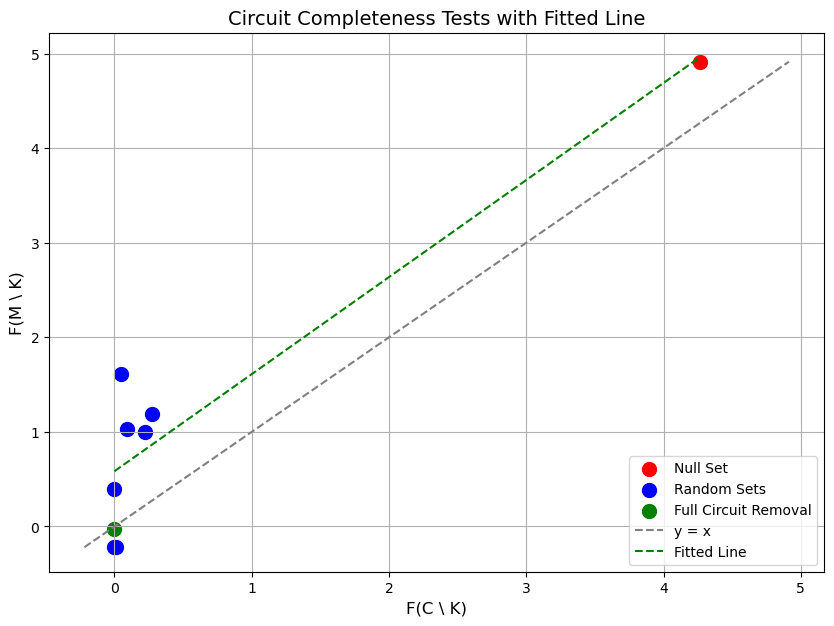

In [95]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
# Extract x and y values
# Separate the data into two groups
# Separate the data into two groups
null_set_xy = xy[0]
random_sets_xy = xy[1:-1]
full_circ_rem = xy[-1]

# Extract x and y values for linear regression
all_x = [point[0] for point in xy[:-1]]
all_y = [point[1] for point in xy[:-1]]

# Fit a linear regression model
regressor = LinearRegression()
all_x_reshaped = np.array(all_x).reshape(-1, 1)  # Reshape for sklearn
regressor.fit(all_x_reshaped, all_y)

# Generate points for the fitted line
fitted_x = np.linspace(min(all_x), max(all_x), 100)
fitted_y = regressor.predict(fitted_x.reshape(-1, 1))

# Extract x and y values for each group
null_set_x, null_set_y = null_set_xy
random_x = [point[0] for point in random_sets_xy]
random_y = [point[1] for point in random_sets_xy]
full_circ_x, full_circ_y = full_circ_rem
# Plot
plt.figure(figsize=(10, 7))

# Null set
plt.scatter(null_set_x, null_set_y, color='red', label='Null Set', s=100)

# Random sets
plt.scatter(random_x, random_y, color='blue', label='Random Sets', s=100)

# Full circuit removal
plt.scatter(full_circ_x, full_circ_y, color='green', label='Full Circuit Removal', s=100)

# Add reference line y = x
x_line = [min([null_set_x] + random_x + [null_set_y] + random_y), max([null_set_x] + random_x + [null_set_y] + random_y)]
plt.plot(x_line, x_line, linestyle="--", color="gray", label="y = x")

# Add fitted regression line
plt.plot(fitted_x, fitted_y, linestyle="--", color="green", label="Fitted Line")

# Customize plot
plt.title("Circuit Completeness Tests with Fitted Line", fontsize=14)
plt.xlabel("F(C \\ K)", fontsize=12)
plt.ylabel("F(M \\ K)", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)

# Show plot
plt.show()


In [ ]:
from transformer_lens.utils import test_prompt
# for sae in saes:
#     model.add_sae(sae)
prompt = ">>> data = [9,1,6] # ignore this comment please \n>>> data[5]\n"
print(len(model.tokenizer(prompt)["input_ids"]))
test_prompt(prompt, "5", model, prepend_space_to_answer=False)
# model.reset_hooks(including_permanent=True)
# model.reset_saes()

In [ ]:
clean_try = model.to_tokens(">>> data = [9,1,6] # ignore this comment please \n>>> print(data[5])\n")

In [ ]:
logits = model.run_with_hooks(
            clean_try, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(clean_try, use_mask=False, mean_mask=False)
            )
# Extract logits for the last position (last token in sequence)
last_logits = logits[:, -1, :]  # Shape: [1, 256000]

# Get the top 10 tokens and their probabilities
top_k_values, top_k_indices = torch.topk(last_logits, k=10, dim=-1)

model.to_str_tokens(top_k_indices)

In [ ]:
from transformer_lens.utils import test_prompt
prompt = ">>> data = [4,7,5,3]\n>>> data[5]\n"
print(len(model.tokenizer(prompt)["input_ids"]))
test_prompt(prompt, "Traceback", model, prepend_space_to_answer=False)

In [ ]:
prompt = ">>> data = [4, 7, 5, 9] # comment \n>>> data[4]\n"
print(len(model.tokenizer(prompt)["input_ids"]))

In [ ]:
import random
import string
import json

def generate_index_error_dataset(num_prompts, N, K, output_path):
    """
    Generate a JSON dataset of prompts with and without index errors.

    Args:
        num_prompts (int): Number of prompt pairs to generate.
        N (int): Length of the list to generate.
        K (int): Number of digits for the integers in the list.
        output_path (str): Path to save the generated dataset as a JSON file.

    Returns:
        None: Saves the dataset to the specified JSON file.
    """
    dataset = []
    var_names = ["age", "scores", "values", "data", "items"]  # Pool of variable names to choose from
    
    for _ in range(num_prompts):
        var_name = random.choice(var_names)
        # Generate a list of length N with random integers of K digits
        random_list = [random.randint(10**(K-1), 10**K - 1) for _ in range(N)]
        
        # Generate valid and invalid indices
        valid_index = random.randint(0, N - 1)
        invalid_index = N + random.randint(1, 5)  # Index out of bounds

        # Extract the answer for the valid index (first digit of the value at the index)
        valid_value = random_list[valid_index]
        no_error_answer = str(valid_value)[0]
        
        # Define the prompts
        no_error_prompt = f""">>> {var_name} = {random_list}\n>>> var = {var_name}[{valid_index}]\n"""
        index_error_prompt = f""">>> {var_name} = {random_list}\n>>> var = {var_name}[{invalid_index}]\n"""

        # Create the first entry (no error prompt as clean, index error as patch)
        # dataset.append({
        #     "clean_prefix": no_error_prompt,
        #     "patch_prefix": index_error_prompt,
        #     "clean_answer": no_error_answer,
        #     "patch_answer": "Traceback",
        #     "case": f"index_len{N}_digit{K}_no_err"
        # })

        # Create the second entry (index error prompt as clean, no error as patch)
        dataset.append({
            "clean_prefix": index_error_prompt,
            "patch_prefix": no_error_prompt,
            "clean_answer": "Traceback",
            "patch_answer": ">>>",
            "case": f"index_len{N}_digit{K}_err"
        })

    save_path = os.path.join(output_path, f"data_len{N}_digit{K}_errOnly.json")
    # Save the dataset to a JSON file
    with open(save_path, "w") as json_file:
        json.dump(dataset, json_file, indent=2)

    # Display confirmation
    print(f"Dataset saved to {save_path}")

# Example usage
num_prompts = 10000
output_path = "data/codereason/index/"
generate_index_error_dataset(num_prompts, N=5, K=1, output_path=output_path)

import random
import string
import json

def generate_index_error_dataset(num_prompts, N, K, output_path):
    """
    Generate a JSON dataset of prompts with and without index errors.

    Args:
        num_prompts (int): Number of prompt pairs to generate.
        N (int): Length of the list to generate.
        K (int): Number of digits for the integers in the list.
        output_path (str): Path to save the generated dataset as a JSON file.

    Returns:
        None: Saves the dataset to the specified JSON file.
    """
    dataset = []
    var_names = ["age", "scores", "values", "data", "items"]  # Pool of variable names to choose from
    
    for _ in range(num_prompts):
        var_name = random.choice(var_names)
        # Generate a list of length N with random integers of K digits
        random_list = [random.randint(10**(K-1), 10**K - 1) for _ in range(N)]
        random_shorter_list = random_list[:N-3]
        # Generate valid and invalid indices
        # valid_index = random.randint(0, N - 1)
        # invalid_index = N + random.randint(1, 5)  # Index out of bounds

        # Extract the answer for the valid index (first digit of the value at the index)
        # valid_value = random_list[valid_index]
        # no_error_answer = str(valid_value)[0]
        valid_index = N-1
        valid_value = str(random_list[valid_index])
        # Define the prompts
        str_list = str(random_list).replace(" ", "")
        str_shorter_list = str(random_shorter_list).replace(" ", "")
        no_error_prompt = f""">>> {var_name} = {str_list}\n>>> print({var_name}[{valid_index}])\n"""
        index_error_prompt = f""">>> {var_name} = {str_shorter_list} # ignore this comment please \n>>> print({var_name}[{valid_index}])\n"""

        # Create the second entry (index error prompt as clean, no error as patch)
        dataset.append({
            "clean_prefix": index_error_prompt,
            "patch_prefix": no_error_prompt,
            "clean_answer": "Traceback",
            "patch_answer": valid_value,
            "case": f"index_len{N}_digit{K}_err"
        })

    save_path = os.path.join(output_path, f"data_len{N}_digit{K}_errOnly_output.json")
    # Save the dataset to a JSON file
    with open(save_path, "w") as json_file:
        json.dump(dataset, json_file, indent=2)

    # Display confirmation
    print(f"Dataset saved to {save_path}")

# Example usage
num_prompts = 10000
output_path = "data/codereason/index/"
generate_index_error_dataset(num_prompts, N=5, K=1, output_path=output_path)
